## Introduction to Data Science

### Exploratory Data Analysis for Natural Language Processing: 
#### A Complete Guide to Python Tools 

In [1]:
import os
import pathlib
import time
import codecs
import string
import re
from collections import Counter
from collections import defaultdict

import urllib
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import networkx as nx
import gensim
from wordcloud import WordCloud
import textract
import pyLDAvis
import pyLDAvis.gensim
import spacy
import textstat
import textblob

from IPython.core.display import Image
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Specifying the path to the files

In [2]:
datapath = pathlib.Path("../datasets/")
outputs = pathlib.Path("../outputs/")

oplexicon = 'Oplexicon_v3.0/lexico_v3.0.txt'

Examinando os arquivos e pastas:

In [3]:
onlydirs = [f for f in os.listdir(datapath) if os.path.isdir(os.path.join(datapath,f)) and not f.startswith('.')]
onlydirs

['Names',
 'Figs',
 'Oplexicon_v3.0',
 'CSVs',
 'Word2vec',
 'Kaggle',
 'Miscellaneous',
 'AVidhya',
 'Texts']

In [4]:
corpuspath = datapath / 'Texts'
onlyfiles = [f for f in os.listdir(corpuspath) if os.path.isfile(os.path.join(corpuspath,f)) and not f.startswith('.')]
onlydirs.sort()

print('Files in the folder:')
for i, w in enumerate(onlyfiles[0:]):
    print(i+1, '--' ,w)

Files in the folder:
1 -- RobertFrost_Poetry.pdf
2 -- AldousHuxley_bravenewworld.pdf
3 -- MarcelProust_EmBuscadoTempoPerdido.pdf
4 -- ARTIGOS-RBE-COM-RESUMO.xlsx


## Example 1

Loading first corpus:

In [5]:
df = pd.read_excel(os.path.join(corpuspath, 'ARTIGOS-RBE-COM-RESUMO.xlsx'))
df.head()

N                         Revista  \
0  1  Revista Brasileira de Economia   
1  2  Revista Brasileira de Economia   
2  3  Revista Brasileira de Economia   
3  4  Revista Brasileira de Economia   
4  5  Revista Brasileira de Economia   

                                    Título do artigo  \
0  Miséria ou Abundância: Alguns Modelos de Cresc...   
1  Comentário sobre o Modelo Econométrico de Tint...   
2  Modernização e desigualdade na agricultura bra...   
3        Optimal Insider Strategy with Law Penalties   
4  Demands for Short-Run Assets and Liabilities i...   

                                              Resumo  Volume Número   Ano  \
0                                                NaN      20      1  1966   
1                                                NaN      25      1  1971   
2                                                NaN      43      2  1989   
3  We study the optimal continuous trading strate...      70      1  2016   
4                                                NaN      60      1  2006   

                                             Autores  Nº de Autores  \
0                              Kingston, Lúcia Silva              1   
1  Fioravante, Moacyr;Naylor, Thomas H.;Monteiro,...              3   
2               Hoffmann, Rodolfo;Kassouf, Ana Lúcia              2   
3                                      Fajardo, Jose              1   
4                    Silva, Evandro;Resende, Marcelo              2   

                                                 URL  
0  http://bibliotecadigital.fgv.br/ojs/index.php/...  
1  http://bibliotecadigital.fgv.br/ojs/index.php/...  
2  http://bibliotecadigital.fgv.br/ojs/index.php/...  
3  http://bibliotecadigital.fgv.br/ojs/index.php/...  
4  http://bibliotecadigital.fgv.br/ojs/index.php/...

In [6]:
df.columns

Index(['N', 'Revista', 'Título do artigo', 'Resumo', 'Volume', 'Número', 'Ano',
       'Autores', 'Nº de Autores', 'URL'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   N                 1556 non-null   int64 
 1   Revista           1556 non-null   object
 2   Título do artigo  1556 non-null   object
 3   Resumo            330 non-null    object
 4   Volume            1556 non-null   int64 
 5   Número            1556 non-null   object
 6   Ano               1556 non-null   int64 
 7   Autores           1556 non-null   object
 8   Nº de Autores     1556 non-null   int64 
 9   URL               1556 non-null   object
dtypes: int64(4), object(6)
memory usage: 121.7+ KB


In [8]:
df['text'] = df['Título do artigo'] + " "
texts = df['text'].sum()
texts[0:1000]

'Miséria ou Abundância: Alguns Modelos de Crescimento para Economias Subdesenvolvidas Comentário sobre o Modelo Econométrico de Tinther, para o Brasil Modernização e desigualdade na agricultura brasileira Optimal Insider Strategy with Law Penalties Demands for Short-Run Assets and Liabilities in Brazil: a Portfolio Approach Alguns Reparos sobre a Teoria do Multiplicador INTRODUÇÃO: ORIGENS HISTÓRICAS DO SUBDESENVOLVIMENTO CONTEMPORÂNEO Princípios para a reformulação da política comercial brasileira A reforma da economia socialista: lições dos primeiros três anos Intensidades fatoriais na economia brasileira: novo teste empírico do teorema de Heckscher-Ohlin Algumas Considerações sobre as Fases do Desenvolvimento Econõmico Poupança e crescimento econômico Padrões de Convergência e Divergência do Crescimento Econômico Regional e das Migrações no Brasil - 1940-1960 Octavio Gouveia de Bulhões - Orientação e Controle da Economia The Economic Theory of Regulation: the Case of Agrarian Reform

In [9]:
stop_pt = nltk.corpus.stopwords.words('portuguese')
stop_en = nltk.corpus.stopwords.words('english')
stopwords = stop_en + stop_pt
stopwords.extend(['-',''])

In [10]:
list_words = texts.split()
list_words = [l.strip().lower() for l in list_words]
list_words = [l.strip(string.punctuation) for l in list_words]
list_words = [l for l in list_words if l not in stopwords]

freqdist = Counter(list_words)
freqdist.most_common(20)

[('brasil', 271),
 ('sobre', 141),
 ('brasileira', 96),
 ('desenvolvimento', 96),
 ('política', 87),
 ('economia', 87),
 ('econômico', 85),
 ('análise', 82),
 ('inflação', 74),
 ('brazil', 66),
 ('econômica', 59),
 ('modelo', 53),
 ('renda', 50),
 ('preços', 50),
 ('monetária', 50),
 ('crescimento', 49),
 ('teoria', 48),
 ('brasileiro', 48),
 ('brazilian', 46),
 ('mercado', 44)]

In [11]:
cleaned = ' '.join(list_words)
wordcloud = WordCloud().generate(cleaned)

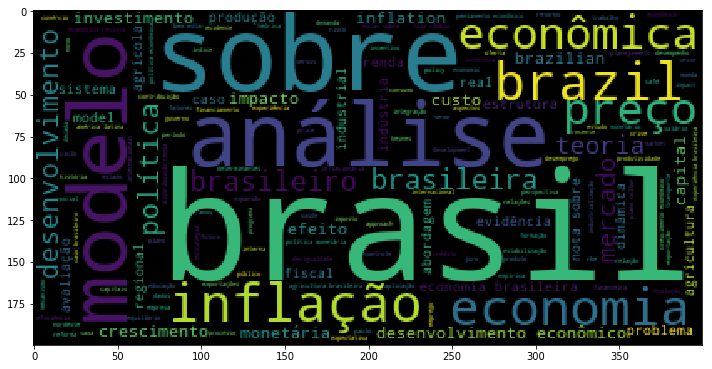

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(wordcloud, interpolation='nearest')
plt.tight_layout()

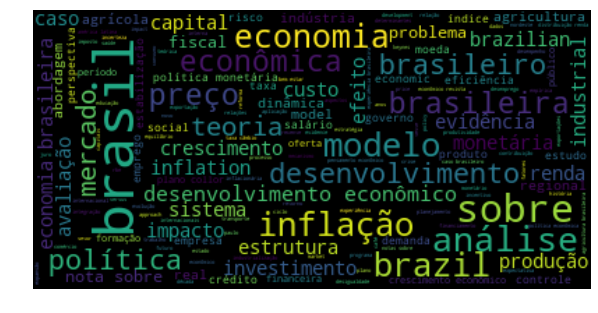

In [13]:
# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(cleaned)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [14]:
# The pil way (if you don't have matplotlib)
image = wordcloud.to_image()
image.show()

## Example 2

In [15]:
print('Files in the folder:')
for i, w in enumerate(onlyfiles[0:]):
    print(i+1, '--' ,w)

Files in the folder:
1 -- RobertFrost_Poetry.pdf
2 -- AldousHuxley_bravenewworld.pdf
3 -- MarcelProust_EmBuscadoTempoPerdido.pdf
4 -- ARTIGOS-RBE-COM-RESUMO.xlsx


In [16]:
raw_texts = ''
for filename in [f for f in onlyfiles if f.endswith('pdf')]:
    text = textract.process(os.path.join(corpuspath,filename)).decode('utf-8')
    print('\nTexto:\n', text[0:50])
    raw_texts += '\n'+ text


Texto:
 Classic Poetry Series

Robert Frost
- poems -

Pub

Texto:
 Brave New World
Aldous Leonard Huxley
February 6, 

Texto:
 MARCEL PROUST
EM BUSCA DO TEMPO PERDIDO

EM BUSCA 


In [17]:
print(len(raw_texts))

7342550


Cleaning and homogenizing texts:

In [18]:
cleaned_texts = raw_texts.lower()
cleaned_texts = re.sub(' +',' ', cleaned_texts) #Remove multiple spaces
cleaned_texts = re.sub(r'\n\s*\n', '\n', cleaned_texts)

In [19]:
print(len(cleaned_texts))

7339946


In [20]:
print(cleaned_texts[0:200])


classic poetry series
robert frost
- poems -
publication date:
2004
publisher:
poemhunter.com - the world's poetry archive
"in white": frost's early version of design
a dented spider like a snow dro


In [21]:
list_words = cleaned_texts.split()
list_words = [l.strip().lower() for l in list_words]
list_words = [l.strip(string.punctuation) for l in list_words]
list_words = [l for l in list_words if l not in stopwords]

freqdist = Counter(list_words)
freqdist.most_common(20)

[('é', 6892),
 ('tão', 3050),
 ('sra', 3014),
 ('bem', 2740),
 ('pois', 2667),
 ('sr', 2536),
 ('albertine', 2402),
 ('ainda', 2276),
 ('ser', 2211),
 ('tempo', 2209),
 ('mim', 2148),
 ('ter', 2045),
 ('casa', 2018),
 ('onde', 1960),
 ('havia', 1871),
 ('vida', 1771),
 ('swann', 1766),
 ('guermantes', 1729),
 ('assim', 1689),
 ('menos', 1688)]

Finding ocurrences of an expression:

In [22]:
expression = 'life'
pos = 0 
positions = []
while pos != -1:
    position = cleaned_texts.find(expression,pos+1)
    pos = position
    positions.append(position)
positions.pop()
print('The expression is found {} times'.format(len(positions)))

The expression is found 64 times


Understanding contexts in which words occur:

In [23]:
# Pure Python
window = 11
for position in positions[0:10]:
    print(cleaned_texts[position - window:position + window + len(expression)].strip())

e piece of lifeless satin
her young life to his.
th
was in my life alone,
wor
tions,
and life is too muc
ay back to life
and living
e piece of lifeless satin
l.
late in life i have com
n with our life,
and look
o keep
the life from spill
o keep
the life from spill


In [24]:
# Using NLTK
tknzr = nltk.tokenize.WordPunctTokenizer()
tokens = tknzr.tokenize(cleaned_texts)
nltk_text = nltk.Text(tokens)
nltk_text.concordance(expression.lower(), width=120, lines=20)

Displaying 20 of 50 matches:
 take care of such a creature , and accommodate her young life to his . that was what marrying father meant to her . she
 alone somehow must have gotten abroad , word i was in my life alone , word i had no one left but god . robert frost www
k to be . it ' s when i ' m weary of considerations , and life is too much like a pathless wood where your face burns an
minds are turned and making the best of their way back to life and living people , and things they understand . but the 
om so small they might as well have none at all . late in life i have come on fern . now lichens are due to have their t
no harm is done . we may as well go patiently on with our life , and look elsewhere than to stars and moon and sun for t
g up the hand half in appeal , but half as if to keep the life from spilling . then the boy saw all since he was old eno
g up the hand half in appeal , but half as if to keep the life from spilling . then the boy saw all - since he was old e
to 

Words that occur in similar contexts than the query expression:

In [25]:
nltk_text.similar(expression)

bed head course voice hand face room feet you say look man her friend
eyes tone arms ears death do


[Collocations](http://en.wikipedia.org/wiki/Collocation) are expressions of multiple words which commonly co-occur.  
http://www.nltk.org/howto/collocations.html  

In [26]:
#nltk_text.collocations(num=10, window_size=20)
print('; '.join(nltk_text.collocation_list(num=20, window_size=20)))  # bug https://github.com/nltk/nltk_book/issues/224

saint loup; minha avó; muitas vezes; sra verdurin; sem dúvida; além disso; sra villeparisis; sra guermantes; poemhunter archive; poemhunter poetry; poetry archive; www archive; www poemhunter; www poetry; que não; poemhunter world; www world; world archive; world poetry; minha mãe


Below we are using [Pointwise Mutual Information](http://en.wikipedia.org/wiki/Pointwise_mutual_information).

In [27]:
max_items = 30
freq_min_b = 10
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder2 = nltk.collocations.BigramCollocationFinder.from_words(nltk_text)
finder2.apply_word_filter(lambda w: w in string.punctuation)
finder2.apply_freq_filter(freq_min_b)
for a, b in finder2.nbest(bigram_measures.pmi, max_items):
    print(a, b)

sarah bernhardt
fernando py
1 °
george sand
mustapha mond
vossa senhoria
victor hugo
lanterna mágica
synthetic music
jesus cristo
brave new
du boulbon
luís xiv
século xix
marcel proust
helmholtz watson
vossa alteza
século xviii
des laumes
século xvii
le champi
françoís le
frost www
poetry archive
greater being
condessa molé
henry foster
etc .,
rei teodósio
reunião noturna


In [28]:
for a, b in (finder2.above_score(bigram_measures.raw_freq, 1000.0 / len(list(nltk.bigrams(tokens))))):
        print(a, b)

que o
o que
que não
que a
de um
em que
de uma
e que
que eu
que se
de que
a sra
que ela
o sr
que me
de guermantes
que ele
e a
do que
com a
não se
de charlus
de sua
com o
o seu
e o
e de
como se


In [29]:
max_items = 30
freq_min_t = 6
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder3 = nltk.collocations.TrigramCollocationFinder.from_words(nltk_text)
finder3.apply_word_filter(lambda w: w in string.punctuation)
finder3.apply_ngram_filter(lambda w1, w2, w3:  w1 in ['da', 'de', 'das'])
finder3.apply_freq_filter(freq_min_t)
for a, b, c in finder3.nbest(trigram_measures.pmi, max_items):
    print(a, b, c)

bel et bien
des deux mondes
revue des deux
françoís le champi
better than mending
brave new world
ending is better
snarled and rattled
shrugged his shoulders
doutor du boulbon
said mustapha mond
half an hour
robert frost www
the assistant predestinator
dia 1 °
years ’ war
s poetry archive
encarregada das duchas
três quartas partes
trinta mil francos
the deputy sub
alameda das acácias
nine years ’
shook his head
princesa des laumes
príncipe des laumes
belongs to every
every one else
crepe da china
shook her head


In [30]:
for a, b, c in finder3.above_score(trigram_measures.raw_freq,100.0 / len(list(nltk.trigrams(tokens)))):
        print (a, b, c)

momento em que
tudo o que
uma espécie de
que o sr
que a sra
ao mesmo tempo
dia em que
que eu não
a impressão de
a fim de
que não se
em vez de
no momento em
ao passo que
em que a
que ela não
na casa da
a idéia de
duquesa de guermantes
em todo caso
todos os dias
casa da sra
que já não
em que o
em que eu
em que se
no dia seguinte
o que me
que o senhor
por um instante
idéia de que
o que se
ponto de vista
mais do que
mais ou menos
o nome de
e que não
por outro lado
o que eu
pela primeira vez
que ele não
s poetry archive
a princesa de
as pessoas que
que a gente
cada vez que
por um momento
don ’ t
em que ela
que não me
um pouco de
é verdade que
robert frost www
a duquesa de
a ponto de
o que não
o que é
por muito tempo
a não ser
princesa de guermantes
a um tempo
que não é
por mais que
princesa de parma
em sua casa
que ela me


In [31]:
from nltk.util import ngrams
n = 4
xgrams = ngrams(tokens, n)
xgrams_counter = Counter(xgrams)
xgrams_counter.most_common(20)

[(('o', 'sr', '.', 'de'), 1317),
 (('sr', '.', 'de', 'charlus'), 1081),
 (('a', 'sra', '.', 'de'), 936),
 (('sra', '.', 'de', 'guermantes'), 508),
 (('a', 'sra', '.', 'verdurin'), 430),
 (('da', 'sra', '.', 'de'), 392),
 (('sra', '.', 'de', 'villeparisis'), 332),
 (('do', 'sr', '.', 'de'), 307),
 (('.', 'de', 'charlus', ','), 305),
 (('que', 'o', 'sr', '.'), 270),
 (('que', 'a', 'sra', '.'), 266),
 ((',', 'a', 'sra', '.'), 249),
 ((',', 'o', 'sr', '.'), 248),
 (('de', 'saint', '-', 'loup'), 240),
 (('.', 'de', 'guermantes', ','), 235),
 (('sr', '.', 'de', 'norpois'), 228),
 (('no', 'momento', 'em', 'que'), 219),
 (('saint', '-', 'loup', ','), 217),
 (('sra', '.', 'verdurin', ','), 191),
 (('a', 'sra', '.', 'swann'), 188)]

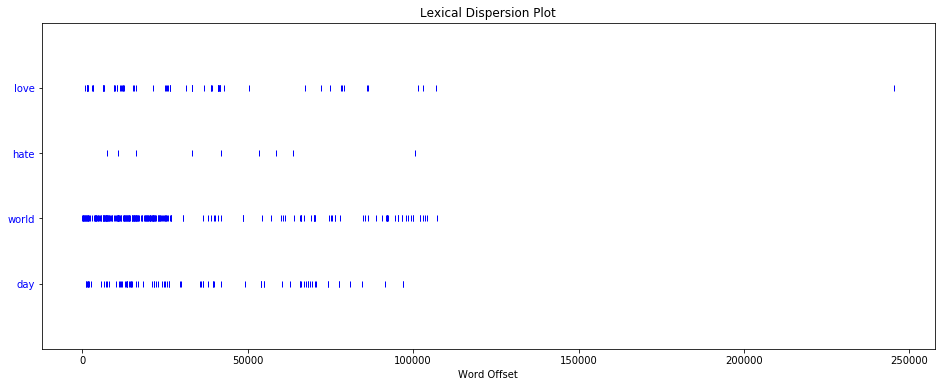

In [32]:
dispersion_words = ['love', 'hate', 'world', 'day']
plt.figure(figsize=(16,6))
nltk_text.dispersion_plot(dispersion_words)

Different ways to visualize frequent words:

In [33]:
freqdist.most_common(100)

[('é', 6892),
 ('tão', 3050),
 ('sra', 3014),
 ('bem', 2740),
 ('pois', 2667),
 ('sr', 2536),
 ('albertine', 2402),
 ('ainda', 2276),
 ('ser', 2211),
 ('tempo', 2209),
 ('mim', 2148),
 ('ter', 2045),
 ('casa', 2018),
 ('onde', 1960),
 ('havia', 1871),
 ('vida', 1771),
 ('swann', 1766),
 ('guermantes', 1729),
 ('assim', 1689),
 ('menos', 1688),
 ('sobre', 1670),
 ('vezes', 1650),
 ('dia', 1580),
 ('vez', 1549),
 ('talvez', 1479),
 ('todos', 1420),
 ('pouco', 1405),
 ('disse', 1403),
 ('pessoas', 1392),
 ('fazer', 1389),
 ('tanto', 1383),
 ('sempre', 1377),
 ('dizer', 1360),
 ('modo', 1347),
 ('nada', 1332),
 ('porque', 1312),
 ('então', 1307),
 ('tudo', 1296),
 ('charlus', 1243),
 ('momento', 1202),
 ('antes', 1168),
 ('outro', 1149),
 ('mulher', 1147),
 ('verdurin', 1145),
 ('apenas', 1139),
 ('todo', 1138),
 ('senhor', 1131),
 ('mesma', 1122),
 ('ver', 1120),
 ('quanto', 1078),
 ('olhos', 1065),
 ('grande', 1063),
 ('todas', 1047),
 ('agora', 994),
 ('diante', 991),
 ('outra', 968),
 

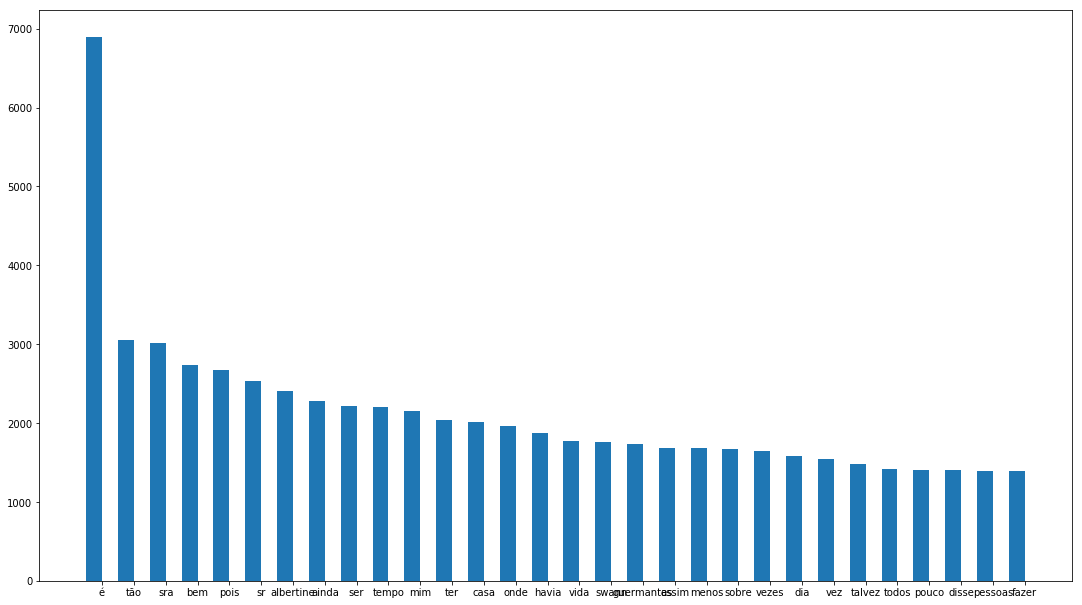

In [34]:
labels, values = zip(*freqdist.most_common(30))

indexes = np.arange(len(labels))
width = 0.5

plt.bar(indexes, values, width)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

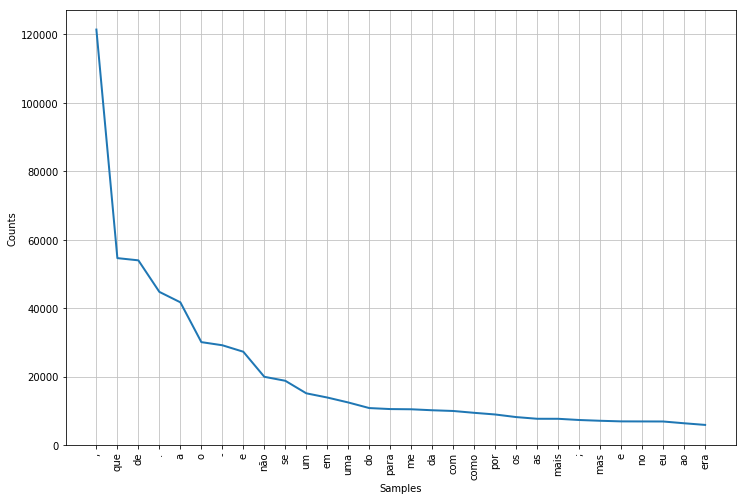

In [35]:
fd_words = nltk.FreqDist(tokens)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,8)) 
fd_words.plot(30)

Cumulative distribution of frequencies:

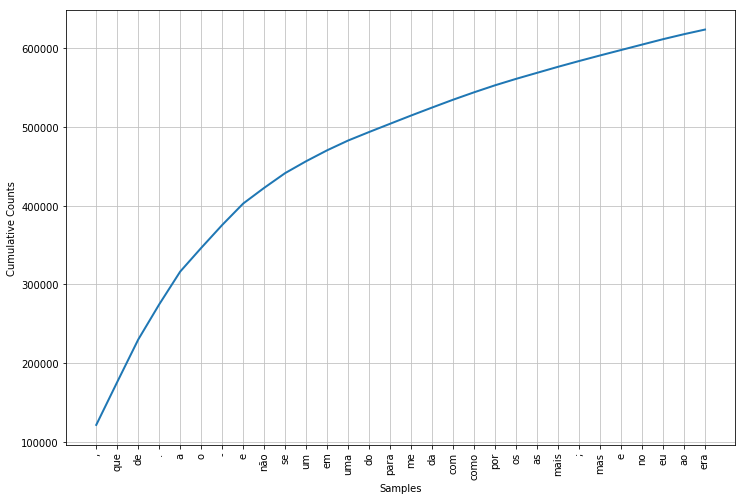

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,8)) 
fd_words.plot(30, cumulative = True)

Automated abstracts (not comparable to human made abstracts)

In [37]:
def score_sentences(sentences, important_words):
    # Approach taken from "The Automatic Creation of Literature Abstracts" by H.P. Luhn
    CLUSTER_THRESHOLD = 5  # Distance between words to consider
    scores = []
    sentence_idx = -1
    #for s in [nltk.tokenize.word_tokenize(s) for s in sentences]:
    punktw2 = nltk.tokenize.WordPunctTokenizer() #trocando pelo punkt (melhor?)
    for s in [punktw2.tokenize(s) for s in sentences]:    
        sentence_idx += 1
        word_idx = []
        # For each word in the word list...
        for w in important_words:
            try:
                # Compute an index for where any important words occur in the sentence
                word_idx.append(s.index(w))
            except ValueError as e: # w not in this particular sentence
                pass
        word_idx.sort()
        # It is possible that some sentences may not contain any important words at all
        if len(word_idx)== 0: continue
        # Using the word index, compute clusters by using a max distance threshold
        # for any two consecutive words
        clusters = []
        cluster = [word_idx[0]]
        i = 1
        while i < len(word_idx):
            if word_idx[i] - word_idx[i - 1] < CLUSTER_THRESHOLD:
                cluster.append(word_idx[i])
            else:
                clusters.append(cluster[:])
                cluster = [word_idx[i]]
            i += 1
        clusters.append(cluster)
        # Score each cluster. The max score for any given cluster is the score 
        # for the sentence
        max_cluster_score = 0
        for c in clusters:
            significant_words_in_cluster = len(c)
            total_words_in_cluster = c[-1] - c[0] + 1
            score = 1.0 * significant_words_in_cluster \
                * significant_words_in_cluster / total_words_in_cluster
            if score > max_cluster_score:
                max_cluster_score = score
        scores.append((sentence_idx, score))
    return scores

In [38]:
def summarize(txt):
    N = 100  # Number of words to consider
    punkts = nltk.tokenize.PunktSentenceTokenizer() #trocando pelo punkt (melhor?)
    punktw = nltk.tokenize.WordPunctTokenizer() #trocando pelo punkt (melhor?)
    #sentences = [s for s in nltk.tokenize.sent_tokenize(txt)]
    sentences = [s for s in punkts.tokenize(txt)]
    normalized_sentences = [s.lower() for s in sentences]
    words = [w.lower() for sentence in normalized_sentences for w in punktw.tokenize(sentence)]
    fdist = nltk.FreqDist(words)
    top_n_words = [w[0] for w in fdist.items() if w[0] not in stopwords][:N]
    scored_sentences = score_sentences(normalized_sentences, top_n_words)
    return sentences, top_n_words, scored_sentences

In [39]:
sentences, top_n_words, scored_sentences = summarize(texts)
print(top_n_words)

['miséria', 'abundância', ':', 'alguns', 'modelos', 'crescimento', 'economias', 'subdesenvolvidas', 'comentário', 'sobre', 'modelo', 'econométrico', 'tinther', ',', 'brasil', 'modernização', 'desigualdade', 'agricultura', 'brasileira', 'optimal', 'insider', 'strategy', 'law', 'penalties', 'demands', 'short', 'run', 'assets', 'liabilities', 'brazil', 'portfolio', 'approach', 'reparos', 'teoria', 'multiplicador', 'introdução', 'origens', 'históricas', 'subdesenvolvimento', 'contemporâneo', 'princípios', 'reformulação', 'política', 'comercial', 'reforma', 'economia', 'socialista', 'lições', 'primeiros', 'três', 'anos', 'intensidades', 'fatoriais', 'novo', 'teste', 'empírico', 'teorema', 'heckscher', 'ohlin', 'algumas', 'considerações', 'fases', 'desenvolvimento', 'econõmico', 'poupança', 'econômico', 'padrões', 'convergência', 'divergência', 'regional', 'migrações', '1940', '1960', 'octavio', 'gouveia', 'bulhões', 'orientação', 'controle', 'economic', 'theory', 'regulation', 'case', 'agra

In [40]:
# First approach:
# Filter out non-significant sentences by using the average score plus a
# fraction of the std dev as a filter
avg = np.mean([s[1] for s in scored_sentences])
std = np.std([s[1] for s in scored_sentences])
mean_scored = [(sent_idx, score) for (sent_idx, score) in scored_sentences if score > avg + 0.5 * std]
mean_scored_summary=[sentences[idx] for (idx, score) in mean_scored]
mean_scored_summary = list(set(mean_scored_summary))

for s in mean_scored_summary[0:10]:
    print(s, '\n')

O Pensamento Econômico em Revistas Taxas de juros e depósitos em moeda estrangeira no Brasil: um comentário Metodologia de Avaliação de Custos nas Universidades Públicas: Economias de Escala e de Escopo Models, Simulations and Games A aritmética perversa da política salarial Evolução da Agroindústria Canavieira Brasileira de 1975 a 1995 Problemas do Desenvolvimento Econômico Deságio das LFT e a probabilidade implícita de moratória (Un)Sustainability and reform of the social security system in Brasil: A generational Accounting Approach Impactos de longo prazo de reformas fiscais sobre a economia brasileira A Robust Poverty Profile for Brazil Using Multiple Data Sources Balanço de Pagamentos do Brasil Notas sobre a teoria da inflação The Yugoslav inflation A Contribuição de L.J. 

Maximização de  lucros e controle de preços Sobre os Usos e Abusos da Teoria Econômica Taxas de Câmbio de Equilíbrio: Formulação Teórica e Exemplificação A expansão das exportações e o crescimento econômico: o 

In [41]:
# Second Approach: 
# Return only the top N ranked sentences
TOP_SENTENCES = 10  # Number of sentences to choose on "top n"
top_n_scored = sorted(scored_sentences, key=lambda s: s[1])[-TOP_SENTENCES:]
top_n_scored = sorted(top_n_scored, key=lambda s: s[0])
top_n_summary=[sentences[idx] for (idx, score) in top_n_scored]
top_n_summary = list(set(top_n_summary))

for s in top_n_summary[0:10]:
    print(s, '\n')

Maximização de  lucros e controle de preços Sobre os Usos e Abusos da Teoria Econômica Taxas de Câmbio de Equilíbrio: Formulação Teórica e Exemplificação A expansão das exportações e o crescimento econômico: o caso do Brasil, 1969-84 Uma Análise para o Efeito-Fronteira no Brasil A General-Equilibrium Closed-Form Solution to the Welfare Costs of Inflation Development, technological change and innovation: Schumpeter and the neo-Schumpeterians Análise de custos e benefícios sociais aplicada à indústria carbonífera no vale do Jacuí Teorias econômicas: a meia-verdade temporária Lucratividade na indústria de transformação: empresas multinacionais versus nacionais privadas. 

Miséria ou Abundância: Alguns Modelos de Crescimento para Economias Subdesenvolvidas Comentário sobre o Modelo Econométrico de Tinther, para o Brasil Modernização e desigualdade na agricultura brasileira Optimal Insider Strategy with Law Penalties Demands for Short-Run Assets and Liabilities in Brazil: a Portfolio Approa

## [Goose](https://github.com/goose3/goose3)

Extracting text from html pages  

In [42]:
from goose3 import Goose

url = 'https://edition.cnn.com/2020/03/27/europe/europe-pollution-decline-coronavirus-lockdown-intl/index.html'
g = Goose(Goose({'use_meta_language': False, 'target_language':'en', 'parser_class':'lxml'}))

article = g.extract(url=url)

In [43]:
article.title

'Air pollution drops as Europeans stay at home'

In [44]:
article.meta_description

'Most Europeans are currently living under severe restrictions, stuck at home, desperately hoping for the coronavirus pandemic to pass soon.'

In [45]:
article.cleaned_text[:]

'(CNN) Most Europeans are currently living under severe restrictions, stuck at home, desperately hoping for the coronavirus pandemic to pass soon.\n\nOn the flip side: the air is cleaner than it\'s been in a long time.\n\nThe huge decline in road traffic, air travel and other business activities across Europe has led to sharp reductions in pollution over several major cities, new images published by the European Space Agency show. A similar effect has been recorded across the United States and in China\n\nThe impact of the pandemic-related restrictions on air quality is staggering. In some parts of Europe, the levels of toxic pollutants in the air have been slashed by a half.\n\nBut while the short-term effect might seems positive, experts are warning that the current situation is no solution.\n\n"Addressing long-term air quality problems requires ambitious policies and forward-looking investments," said Hans Bruyninckx, the EEA executive director. "As such, the current crisis and its 

In [46]:
article.top_image

## [Textblob](http://textblob.readthedocs.io/en/dev/)

https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/

Installing:  

!sudo pip3 install -U textblob  
!python -m textblob.download_corpora

In [47]:
from textblob import TextBlob
from textblob import Word

text = '''
The titular threat of The Blob has always struck me as the ultimate movie
monster: an insatiably hungry, amoeba-like mass able to penetrate
virtually any safeguard, capable of--as a doomed doctor chillingly
describes it--"assimilating flesh on contact.
Snide comparisons to gelatin be damned, it's a concept with the most
devastating of potential consequences, not unlike the grey goo scenario
proposed by technological theorists fearful of
artificial intelligence run rampant.
'''

text_pt = '''
Com uma abordagem inédita, o curso de Mestrado em Modelagem Matemática 
integra à Matemática Aplicada o corpo de conhecimentos das Ciências da 
Computação e da Informação, com contextos de aplicações das ciências 
sociais, econômicas, biológicas e da saúde. O curso possibilita ao 
mestrando desenvolver a capacidade de analisar cenários e dar suporte 
à tomada de decisões em situações de uso intensivo de dados e informações, 
além de ter o objetivo de formar excelentes pesquisadores na área.
'''

In [48]:
blob = TextBlob(text)
blob_pt = TextBlob(text_pt)

In [49]:
blob.sentences

[Sentence("
 The titular threat of The Blob has always struck me as the ultimate movie
 monster: an insatiably hungry, amoeba-like mass able to penetrate
 virtually any safeguard, capable of--as a doomed doctor chillingly
 describes it--"assimilating flesh on contact."),
 Sentence("Snide comparisons to gelatin be damned, it's a concept with the most
 devastating of potential consequences, not unlike the grey goo scenario
 proposed by technological theorists fearful of
 artificial intelligence run rampant.")]

In [50]:
blob_pt.sentences

[Sentence("
 Com uma abordagem inédita, o curso de Mestrado em Modelagem Matemática 
 integra à Matemática Aplicada o corpo de conhecimentos das Ciências da 
 Computação e da Informação, com contextos de aplicações das ciências 
 sociais, econômicas, biológicas e da saúde."),
 Sentence("O curso possibilita ao 
 mestrando desenvolver a capacidade de analisar cenários e dar suporte 
 à tomada de decisões em situações de uso intensivo de dados e informações, 
 além de ter o objetivo de formar excelentes pesquisadores na área.")]

In [51]:
blob.sentences[1].words

WordList(['Snide', 'comparisons', 'to', 'gelatin', 'be', 'damned', 'it', "'s", 'a', 'concept', 'with', 'the', 'most', 'devastating', 'of', 'potential', 'consequences', 'not', 'unlike', 'the', 'grey', 'goo', 'scenario', 'proposed', 'by', 'technological', 'theorists', 'fearful', 'of', 'artificial', 'intelligence', 'run', 'rampant'])

Functions applied to the Word object:  

In [52]:
blob.sentences[1].words.singularize()

WordList(['Snide', 'comparison', 'to', 'gelatin', 'be', 'damned', 'it', "'", 'a', 'concept', 'with', 'the', 'most', 'devastating', 'of', 'potential', 'consequence', 'not', 'unlike', 'the', 'grey', 'goo', 'scenario', 'proposed', 'by', 'technological', 'theorist', 'fearful', 'of', 'artificial', 'intelligence', 'run', 'rampant'])

In [53]:
w = Word('Platform')
w.pluralize()

'Platforms'

Lemmatization  

In [54]:
w = Word('running')
w.lemmatize("v") ## v here represents verb

'run'

POS tags  

In [55]:
blob.tags[0:10]

[('The', 'DT'),
 ('titular', 'JJ'),
 ('threat', 'NN'),
 ('of', 'IN'),
 ('The', 'DT'),
 ('Blob', 'NNP'),
 ('has', 'VBZ'),
 ('always', 'RB'),
 ('struck', 'VBN'),
 ('me', 'PRP')]

In [56]:
blob_pt.tags[0:10]

[('Com', 'NNP'),
 ('uma', 'JJ'),
 ('abordagem', 'NN'),
 ('inédita', 'NN'),
 ('o', 'JJ'),
 ('curso', 'NN'),
 ('de', 'IN'),
 ('Mestrado', 'NNP'),
 ('em', 'CC'),
 ('Modelagem', 'NNP')]

Ngrams  

In [57]:
for ngram in blob.ngrams(2):
    print(ngram)

['The', 'titular']
['titular', 'threat']
['threat', 'of']
['of', 'The']
['The', 'Blob']
['Blob', 'has']
['has', 'always']
['always', 'struck']
['struck', 'me']
['me', 'as']
['as', 'the']
['the', 'ultimate']
['ultimate', 'movie']
['movie', 'monster']
['monster', 'an']
['an', 'insatiably']
['insatiably', 'hungry']
['hungry', 'amoeba-like']
['amoeba-like', 'mass']
['mass', 'able']
['able', 'to']
['to', 'penetrate']
['penetrate', 'virtually']
['virtually', 'any']
['any', 'safeguard']
['safeguard', 'capable']
['capable', 'of']
['of', 'as']
['as', 'a']
['a', 'doomed']
['doomed', 'doctor']
['doctor', 'chillingly']
['chillingly', 'describes']
['describes', 'it']
['it', 'assimilating']
['assimilating', 'flesh']
['flesh', 'on']
['on', 'contact']
['contact', 'Snide']
['Snide', 'comparisons']
['comparisons', 'to']
['to', 'gelatin']
['gelatin', 'be']
['be', 'damned']
['damned', 'it']
['it', "'s"]
["'s", 'a']
['a', 'concept']
['concept', 'with']
['with', 'the']
['the', 'most']
['most', 'devastating'

Noun Phrase Extraction

In [58]:
blob.noun_phrases

WordList(['titular threat', 'blob', 'ultimate movie monster', 'amoeba-like mass', 'snide', 'potential consequences', 'grey goo scenario', 'technological theorists fearful', 'artificial intelligence run rampant'])

In [59]:
blob_pt.noun_phrases

WordList(['com', 'uma abordagem inédita', 'o curso', 'mestrado', 'modelagem matemática', 'integra à', 'matemática aplicada', 'o corpo', 'conhecimentos das', 'ciências', 'computação', 'e da', 'informação', 'com contextos', 'aplicações das ciências sociais', 'biológicas e da saúde', 'o curso possibilita ao mestrando desenvolver', 'analisar cenários e dar suporte à tomada', 'decisões em situações', 'uso intensivo', 'dados e informações', 'ter o objetivo', 'formar excelentes pesquisadores na área'])

Sentiment Analysis  

In [60]:
for sentence in blob.sentences:
    print(sentence.sentiment.polarity)

0.06000000000000001
-0.34166666666666673


Translation

In [61]:
blob.translate(to="pt")

TextBlob("A ameaça titular de The Blob sempre me pareceu o melhor filme
monstro: uma massa insaciável de fome, semelhante a ameba, capaz de penetrar
praticamente qualquer salvaguarda, capaz de - como um médico condenado, arrepiante
descreve - "assimilando carne em contato.
Comparações sarcásticas com gelatina, é um conceito com as mais
devastador de possíveis consequências, não muito diferente do cenário de gosma cinzenta
proposto por teóricos tecnológicos temerosos de
inteligência artificial corre solta.")

Detecting language

In [62]:
blob_pt.detect_language()

'pt'

Spellcheck

In [63]:
blob = TextBlob('FGV is the bist think taenk in the word!')
blob.correct()


TextBlob("FGV is the best think tank in the word!")

In [64]:
blob.words[5].spellcheck()

[('tank', 1.0)]

Text classification

In [65]:
training = [
('Tom Holland is a terrible spiderman.','neg'),
('a terrible Javert (Russell Crowe) ruined Les Miserables for me...','neg'),
('The Dark Knight Rises is the greatest superhero movie ever!','pos'),
('Fantastic Four should have never been made.','neg'),
('Wes Anderson is my favorite director!','pos'),
('Captain America 2 is pretty awesome.','pos'),
('Let\s pretend "Batman and Robin" never happened..','neg'),
]

testing = [
('Superman was never an interesting character.','neg'),
('Fantastic Mr Fox is an awesome film!','pos'),
('Dragonball Evolution is simply terrible!!','neg')
]

<input>:8: DeprecationWarning: invalid escape sequence \s
<input>:8: DeprecationWarning: invalid escape sequence \s
<input>:8: DeprecationWarning: invalid escape sequence \s
<ipython-input-65-4fc407588c5c>:8: DeprecationWarning: invalid escape sequence \s
  ('Let\s pretend "Batman and Robin" never happened..','neg'),


In [66]:
from textblob import classifiers
nb_classifier = classifiers.NaiveBayesClassifier(training)
dt_classifier = classifiers.DecisionTreeClassifier(training)

In [67]:
print (nb_classifier.accuracy(testing))

1.0


In [68]:
nb_classifier.show_informative_features(3)

Most Informative Features
            contains(is) = True              pos : neg    =      2.9 : 1.0
      contains(terrible) = False             pos : neg    =      1.8 : 1.0
         contains(never) = False             pos : neg    =      1.8 : 1.0


In [69]:
blob = TextBlob('the weather is terrible!', classifier=dt_classifier)
print (blob.classify())

pos


#### Basic Polarizing Functions for Sentiment Analysis

Loading the polarized lexycom file - OpLexicon (BR)

In [70]:
df_o = pd.read_csv(os.path.join(datapath,oplexicon), header=None, encoding='utf-8', usecols=[0,2], names=[u'palavra',u'polaridade'])
df_o.drop_duplicates(subset=[u'palavra'], keep='first', inplace=True)
df_o = df_o.set_index(u'palavra')
print(u'Corpus com {} palavras polarizadas'.format(len(df_o)))

Corpus com 32119 palavras polarizadas


In [71]:
def polariza_texto(texto, df1):
    polaridades = []
    ausentes = []
    l_palavras = texto.split()
    for palavra in l_palavras:
        p = palavra.lower().strip()
        if p in df1.index:
            polaridades.append(df1.polaridade[p])
        else:
            ausentes.append(p)
    num_pal = len(l_palavras)
    num_pol = len(polaridades)
    razao_pol = num_pol/float(num_pal) if num_pal else 0.0
    polaridade = sum(polaridades)/float(num_pol) if num_pol else 0.0
    #print('Foram polarizadas {} palavras de um total de {} ({:.2%})'.format(num_pol, num_pal, razao_pol))
    #print('A polaridade mensurada do texto é de {:.3}'.format(polaridade))
    return polaridade, ausentes

In [72]:
def polariza_counter(dicionario, df1):
    polaridades = []
    fator_div = 0
    ausentes = []
    for palavra, frequencia in dicionario.iteritems():
        p = palavra.lower().strip()
        if p in df1.index:
            polaridades.append(df1.polaridade[p] * frequencia)
            fator_div += frequencia
        else:
            ausentes.append((palavra,frequencia))
    num_pal = len(dicionario)
    num_pol = len(polaridades)
    razao_pol = num_pol/float(num_pal) if num_pal else 0.0
    polaridade = sum(polaridades)/float(fator_div)
    print('Foram polarizadas {} palavras de um total de {} ({:.2%})'.format(num_pol, num_pal, razao_pol))
    print('A polaridade mensurada do texto é de {:.3}'.format(polaridade))
    return polaridade, ausentes

In [73]:
score, ausentes = polariza_texto(texts, df_o)
print(score)

0.06378132118451026


## [Spacy](https://spacy.io/)

https://spacy.io/usage/spacy-101#lightning-tour  
https://github.com/explosion/spacy-notebooks  
https://github.com/explosion/spacy-notebooks/blob/master/notebooks/conference_notebooks/advanced_text_analysis.ipynb  

In [74]:
import spacy

Load resources and process text

In [75]:
#!ipython -m spacy download en_core_web_sm
#!ipython -m spacy download de_core_news_sm
#!ipython -m spacy download pt_core_news_sm
#!ipython -m spacy download de_core_news_md
!ipython -m spacy validate

✔ Loaded compatibility table

====================== Installed models (spaCy v2.2.4) ======================
ℹ spaCy installation: /usr/local/lib/python3.6/dist-packages/spacy

TYPE      NAME              MODEL             VERSION                            
package   pt-core-news-sm   pt_core_news_sm   2.2.5   ✔
package   en-core-web-sm    en_core_web_sm    2.2.5   ✔
package   de-core-news-sm   de_core_news_sm   2.2.5   ✔
package   de-core-news-md   de_core_news_md   2.2.5   ✔



In [76]:
en_nlp = spacy.load('en_core_web_sm')
de_nlp = spacy.load('de_core_news_sm')
pt_nlp = spacy.load('pt_core_news_sm')

en_doc = en_nlp(text)
de_doc = de_nlp('ich bin ein Berliner.')
pt_doc = pt_nlp(text_pt)

Each SpaCy document is already tokenized into words, which are accessible by iterating over the document:

In [77]:
print(en_doc[0:4])


The titular threat


You can also iterate over the sentences. doc.sents is a generator object, so we can use next():

In [78]:
en_Sents = list(en_doc.sents)
print(en_Sents)

[
The titular threat of The Blob has always struck me as the ultimate movie
monster: an insatiably hungry, amoeba-like mass able to penetrate
virtually any safeguard, capable of--as a doomed doctor chillingly
describes it--"assimilating flesh on contact.
, Snide comparisons to gelatin be damned, it's a concept with the most
devastating of potential consequences, not unlike the grey goo scenario
proposed by technological theorists fearful of
artificial intelligence run rampant.
]


For example, let's find the longest sentence(s) in Pride and Prejudice:

In [79]:
SentenceLengths = [len(sent) for sent in en_Sents]
[sent for sent in en_Sents if len(sent) == max(SentenceLengths)]

[
 The titular threat of The Blob has always struck me as the ultimate movie
 monster: an insatiably hungry, amoeba-like mass able to penetrate
 virtually any safeguard, capable of--as a doomed doctor chillingly
 describes it--"assimilating flesh on contact.]

Exploring Words  
Each word has a crazy number of properties:

In [80]:
en_doc[2]

titular

In [81]:
[prop for prop in dir(en_doc[2]) if not prop.startswith('_')]

['ancestors',
 'check_flag',
 'children',
 'cluster',
 'conjuncts',
 'dep',
 'dep_',
 'doc',
 'ent_id',
 'ent_id_',
 'ent_iob',
 'ent_iob_',
 'ent_kb_id',
 'ent_kb_id_',
 'ent_type',
 'ent_type_',
 'get_extension',
 'has_extension',
 'has_vector',
 'head',
 'i',
 'idx',
 'is_alpha',
 'is_ancestor',
 'is_ascii',
 'is_bracket',
 'is_currency',
 'is_digit',
 'is_left_punct',
 'is_lower',
 'is_oov',
 'is_punct',
 'is_quote',
 'is_right_punct',
 'is_sent_start',
 'is_space',
 'is_stop',
 'is_title',
 'is_upper',
 'lang',
 'lang_',
 'left_edge',
 'lefts',
 'lemma',
 'lemma_',
 'lex_id',
 'like_email',
 'like_num',
 'like_url',
 'lower',
 'lower_',
 'morph',
 'n_lefts',
 'n_rights',
 'nbor',
 'norm',
 'norm_',
 'orth',
 'orth_',
 'pos',
 'pos_',
 'prefix',
 'prefix_',
 'prob',
 'rank',
 'remove_extension',
 'right_edge',
 'rights',
 'sent',
 'sent_start',
 'sentiment',
 'set_extension',
 'shape',
 'shape_',
 'similarity',
 'string',
 'subtree',
 'suffix',
 'suffix_',
 'tag',
 'tag_',
 'tensor

Using just the indices (.i), we can make a lexical dispersion plot for the occurrences of that word in the novel. (This is just the SpaCy equivalent of the lexical dispersion plot from the NLTK)

In [82]:
en_doc[2].i

2

In [83]:
def locations(needle, haystack): 
    """ 
    Make a list of locations, bin those into a histogram, 
    and finally put it into a Pandas Series object so that we
    can later make it into a DataFrame. 
    """
    return pd.Series(np.histogram(
        [word.i for word in haystack 
         if word.text.lower() == needle], bins=50)[0])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f96303ae940>,
      dtype=object)

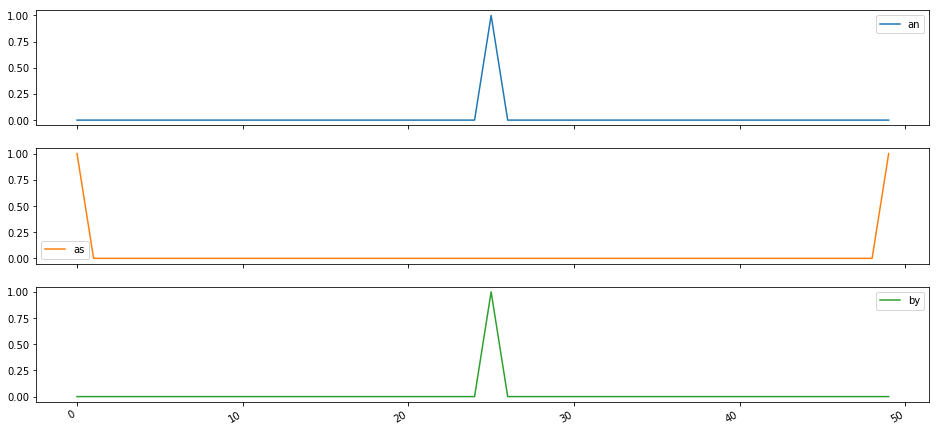

In [84]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8

pd.DataFrame(
    {name: locations(name.lower(), en_doc) 
     for name in ['an', 'as', 'by']}
).plot(subplots=True)

Exploring Named Entities

Named entities can be accessed through doc.ents

In [85]:
set([w.label_ for w in en_doc.ents])

set()

In [86]:
[ent for ent in en_doc.ents if ent.label_ == 'PERSON']

[]

In [87]:
[ent for ent in en_doc.ents if ent.label_ == 'GPE']

[]

Parts of Speech  

Each word already has a part of speech and a tag associated with it.

In [88]:
tagDict = {w.pos: w.pos_ for w in en_doc} 
tagDict

{103: 'SPACE',
 90: 'DET',
 84: 'ADJ',
 92: 'NOUN',
 85: 'ADP',
 96: 'PROPN',
 87: 'AUX',
 86: 'ADV',
 100: 'VERB',
 95: 'PRON',
 98: 'SCONJ',
 97: 'PUNCT',
 94: 'PART'}

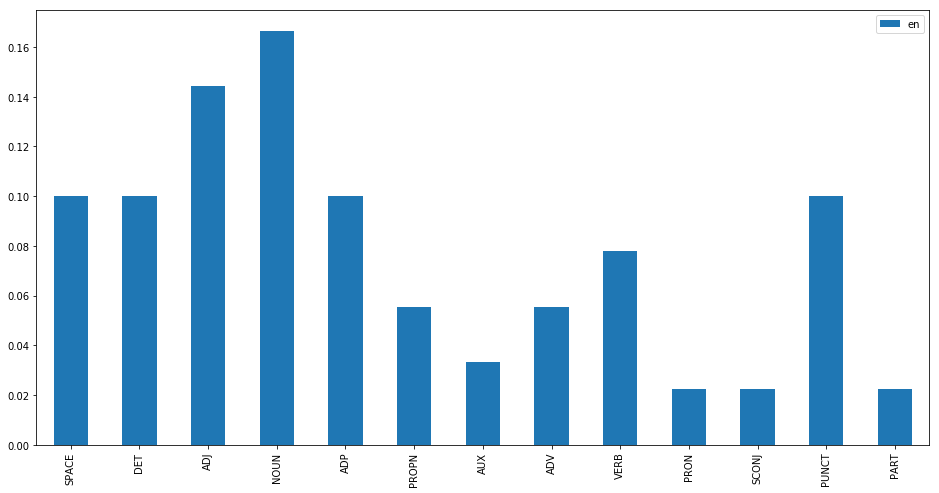

In [89]:
en_docPOS = pd.Series(en_doc.count_by(spacy.attrs.POS))/len(en_doc)

df = pd.DataFrame([en_docPOS], index=['en'])
df.columns = [tagDict[column] for column in df.columns]
df.T.plot(kind='bar')

In [90]:
en_docProns = [w for w in en_doc if w.pos_ == 'PRON']
Counter([w.string.strip() for w in en_docProns]).most_common(10)

[('me', 1), ('it', 1)]

In [91]:
en_docSents = [sent for sent in en_doc.sents if 'of' in sent.string]
en_docSents

[
 The titular threat of The Blob has always struck me as the ultimate movie
 monster: an insatiably hungry, amoeba-like mass able to penetrate
 virtually any safeguard, capable of--as a doomed doctor chillingly
 describes it--"assimilating flesh on contact.,
 Snide comparisons to gelatin be damned, it's a concept with the most
 devastating of potential consequences, not unlike the grey goo scenario
 proposed by technological theorists fearful of
 artificial intelligence run rampant.]

In [92]:
for word in en_docSents[1]: 
    print(word, word.tag_, word.pos_)

Snide NNP PROPN
comparisons NNS NOUN
to IN ADP
gelatin JJ ADJ
be VB AUX
damned VBN VERB
, , PUNCT
it PRP PRON
's VBZ AUX
a DT DET
concept NN NOUN
with IN ADP
the DT DET
most RBS ADV

 _SP SPACE
devastating JJ ADJ
of IN ADP
potential JJ ADJ
consequences NNS NOUN
, , PUNCT
not RB PART
unlike IN ADP
the DT DET
grey NNP PROPN
goo NNP PROPN
scenario NNP PROPN

 _SP SPACE
proposed VBN VERB
by IN ADP
technological JJ ADJ
theorists NNS NOUN
fearful JJ ADJ
of IN ADP

 _SP SPACE
artificial JJ ADJ
intelligence NN NOUN
run VBP VERB
rampant JJ ADJ
. . PUNCT

 _SP SPACE


Dependency Parsing  

Now let's analyze the structure of the sentence.  

This sentence has lots of properties:  

In [93]:
[prop for prop in dir(en_docSents[1]) if not prop.startswith('_')]

['as_doc',
 'char_span',
 'conjuncts',
 'doc',
 'end',
 'end_char',
 'ent_id',
 'ent_id_',
 'ents',
 'get_extension',
 'get_lca_matrix',
 'has_extension',
 'has_vector',
 'kb_id',
 'kb_id_',
 'label',
 'label_',
 'lefts',
 'lemma_',
 'lower_',
 'merge',
 'n_lefts',
 'n_rights',
 'noun_chunks',
 'orth_',
 'remove_extension',
 'rights',
 'root',
 'sent',
 'sentiment',
 'set_extension',
 'similarity',
 'start',
 'start_char',
 'string',
 'subtree',
 'tensor',
 'text',
 'text_with_ws',
 'to_array',
 'upper_',
 'vector',
 'vector_norm',
 'vocab']

To drill down into the sentence, we can start with the root:

In [94]:
en_docSents[1].root

's

In [95]:
list(en_docSents[1].root.children)

[damned, ,, it, concept, .]

In [96]:
for word in en_docSents[1]: 
    print(word, ': ', str(list(word.children)))

Snide :  []
comparisons :  [Snide, to]
to :  [gelatin]
gelatin :  []
be :  []
damned :  [comparisons, be]
, :  []
it :  []
's :  [damned, ,, it, concept, .]
a :  []
concept :  [a, with, ,, not, unlike, run]
with :  [devastating]
the :  []
most :  [
]

 :  []
devastating :  [the, most, of]
of :  [consequences]
potential :  []
consequences :  [potential]
, :  []
not :  []
unlike :  [scenario]
the :  []
grey :  []
goo :  []
scenario :  [the, grey, goo, 
, proposed]

 :  []
proposed :  [by]
by :  [theorists]
technological :  []
theorists :  [technological, fearful]
fearful :  [of]
of :  [
]

 :  []
artificial :  []
intelligence :  [artificial]
run :  [intelligence, rampant]
rampant :  []
. :  [
]

 :  []


In [97]:
for sent in en_docSents: 
    for word in sent: 
        if 'as' in word.string: 
            for child in word.children: 
                if child.pos_ == 'ADJ':
                    print(child)

hungry
like
able


In [98]:
Counter([w.string.strip() for w in en_doc.ents if w.label_ == 'PERSON']).most_common(10)

[]

Now we can write a function that walks down the tree from each character, looking for the first adjectives it can find:

In [99]:
def adjectivesDescribingCharacters(text, character):
    sents = [sent for sent in text.sents if character in sent.string]
    adjectives = []
    for sent in sents: 
        for word in sent: 
            if character in word.string:
                for child in word.children: 
                    if child.pos_ == 'ADJ': 
                        adjectives.append(child.string.strip())
    return Counter(adjectives).most_common(10)

In [100]:
adjectivesDescribingCharacters(en_doc, 'Blob')

[]

or verbs:

In [101]:
def verbsForCharacters(text, character):
    sents = [sent for sent in text.sents if character in sent.string]
    charWords = []
    for sent in sents: 
        for word in sent: 
            if character in word.string: 
                charWords.append(word)
    charAdjectives = []
    for word in charWords: 
        # Start walking up the list of ancestors 
        # Until we get to the first verb. 
        for ancestor in word.ancestors: 
            if ancestor.pos_.startswith('V'): 
                charAdjectives.append(ancestor.lemma_.strip())
    return Counter(charAdjectives).most_common(20)

In [102]:
verbsForCharacters(en_doc, 'Blob')

[('strike', 1)]

Probabilities

SpaCy has a list of probabilities for English words, and these probabilities are automatically associated with each word once we parse the document.  
Let's see what the distribution is like:

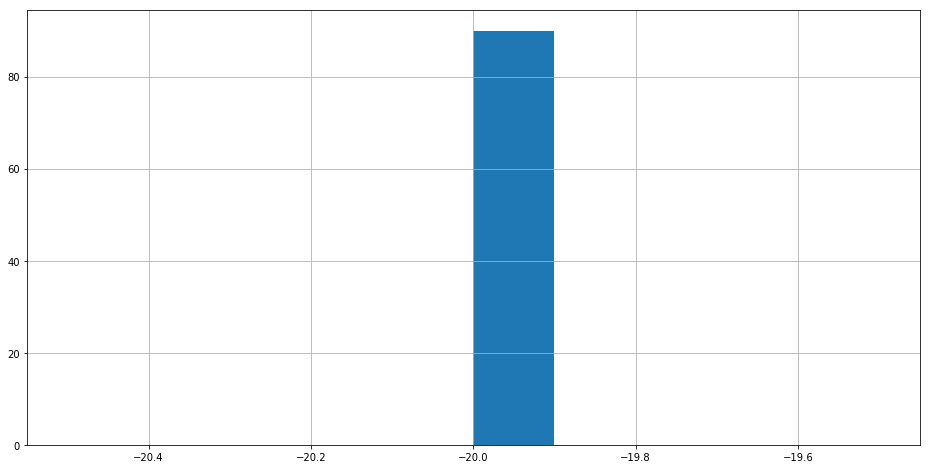

In [103]:
probabilities = [word.prob for word in en_doc] 
pd.Series(probabilities).hist()

Let's peek at some of the improbable words

In [104]:
list(set([word.string.strip().lower() for word in en_doc if word.prob < -19]))[:20]

['',
 'an',
 'titular',
 '--',
 'potential',
 'as',
 'gelatin',
 'of',
 'always',
 'threat',
 'damned',
 'goo',
 'be',
 'run',
 'rampant',
 'amoeba',
 'ultimate',
 'any',
 'snide',
 'theorists']

In [105]:
Counter([word.string.strip().lower() 
         for word in en_doc 
         if word.prob < -19.5]).most_common(20)

[('', 9),
 ('the', 5),
 ('of', 4),
 (',', 4),
 ('as', 2),
 ('to', 2),
 ('a', 2),
 ('.', 2),
 ('titular', 1),
 ('threat', 1),
 ('blob', 1),
 ('has', 1),
 ('always', 1),
 ('struck', 1),
 ('me', 1),
 ('ultimate', 1),
 ('movie', 1),
 ('monster', 1),
 (':', 1),
 ('an', 1)]

In [106]:
def ngrams(doc, n): 
    doc = [word for word in doc 
           if word.is_alpha # Get rid of punctuation
           if not word.string.isupper()] # Get rid of all-caps speaker headings
    return list(zip(*[doc[i:] for i in range(n)]))

In [107]:
docGrams = set(ngrams(en_doc, 3))

In [108]:
for gram in docGrams: 
    if sum([word.prob for word in gram]) < -40: 
        print(gram)

(mass, able, to)
(comparisons, to, gelatin)
(artificial, intelligence, run)
(by, technological, theorists)
(as, the, ultimate)
(titular, threat, of)
(scenario, proposed, by)
(chillingly, describes, flesh)
(threat, of, The)
(doctor, chillingly, describes)
(goo, scenario, proposed)
(virtually, any, safeguard)
(an, insatiably, hungry)
(gelatin, be, damned)
(monster, an, insatiably)
(potential, consequences, not)
(me, as, the)
(flesh, on, contact)
(to, penetrate, virtually)
(ultimate, movie, monster)
(amoeba, like, mass)
(always, struck, me)
(contact, Snide, comparisons)
(consequences, not, unlike)
(The, Blob, has)
(the, ultimate, movie)
(safeguard, capable, of)
(Blob, has, always)
(describes, flesh, on)
(penetrate, virtually, any)
(any, safeguard, capable)
(able, to, penetrate)
(damned, it, a)
(of, The, Blob)
(has, always, struck)
(capable, of, as)
(of, as, a)
(with, the, most)
(a, concept, with)
(Snide, comparisons, to)
(devastating, of, potential)
(intelligence, run, rampant)
(the, most

## Example 3 - Full EDA text pipeline based in [this](https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools) and [this](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/) articles  

### Analyzing text statistics

Text statistics visualizations are simple but very insightful techniques. 

They include:

- word frequency analysis,
- sentence length analysis,
- average word length analysis

In [109]:
news= pd.read_csv(datapath / 'CSVs'/ 'abcnews-date-text.csv',nrows=10000)
news.head(3)

publish_date                                      headline_text
0      20030219  aba decides against community broadcasting lic...
1      20030219     act fire witnesses must be aware of defamation
2      20030219     a g calls for infrastructure protection summit

#### First, let's take a look at the number of characters present in each sentence. This can give us a rough idea about the news headline length.

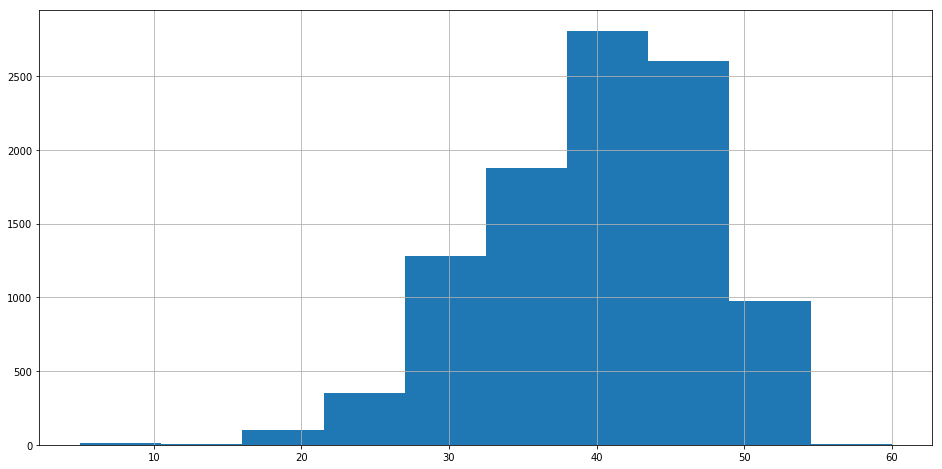

In [110]:
news['headline_text'].str.len().hist()

#### Now, we will move on to data exploration at a word-level. Let’s plot the number of words appearing in each news headline.

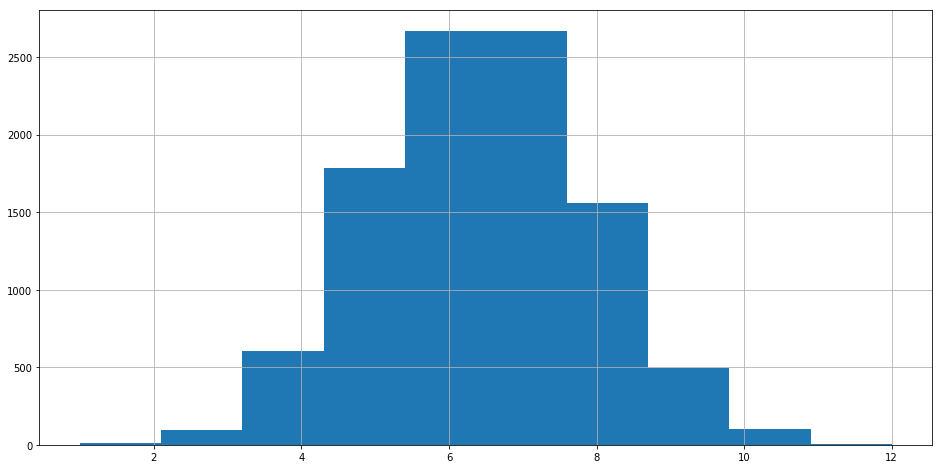

In [111]:
news['headline_text'].str.split().map(lambda x: len(x)).hist()

#### Up next, let’s check the average word length in each sentence.

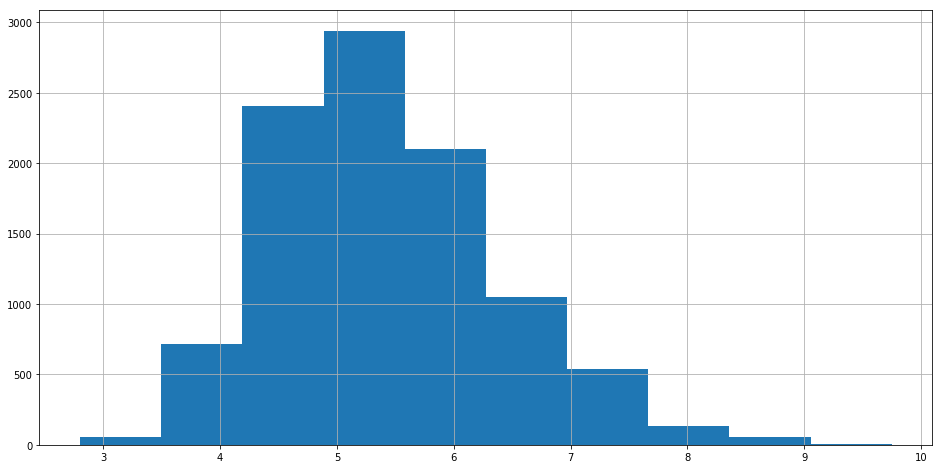

In [112]:
news['headline_text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

#### Loading stopwords list

In [113]:
#import nltk
#nltk.download('stopwords')
stop = set(nltk.corpus.stopwords.words('english'))

#### Now, we’ll  create the corpus.

In [114]:
corpus=[]
new = news['headline_text'].str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]

#### Plot top stopwords

<BarContainer object of 10 artists>

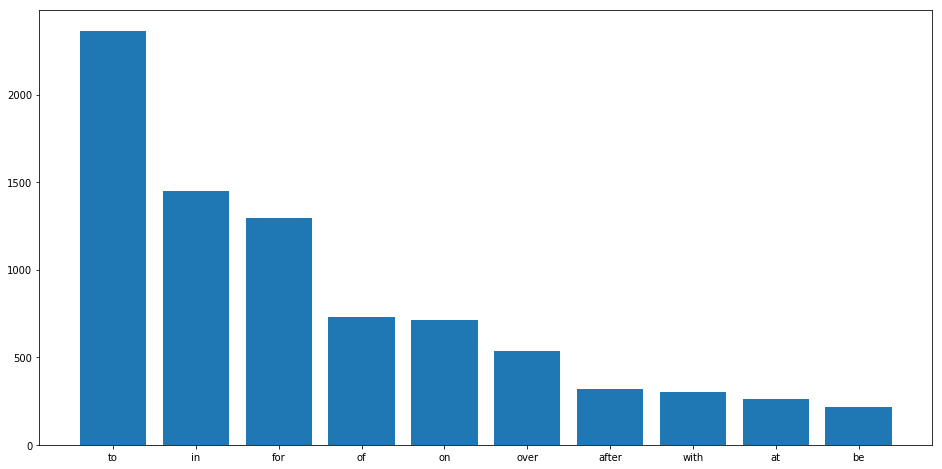

In [115]:
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1
top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y = zip(*top)
plt.bar(x,y)

#### We will use the counter function from the collections library to count and store the occurrences of each word in a list of tuples.

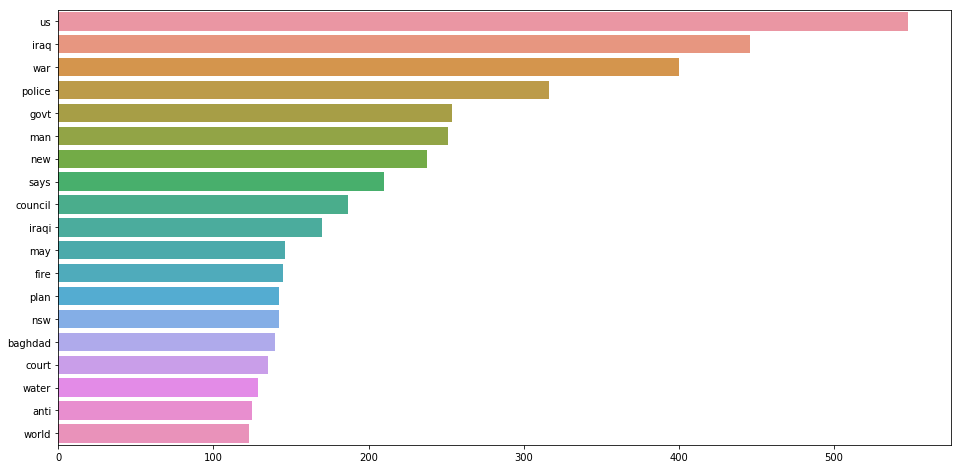

In [116]:
counter = Counter(corpus)
most = counter.most_common()

x, y = [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

#### Ngram exploration  

Ngrams are simply contiguous sequences of n words.   

Looking at most frequent n-grams can give you a better understanding of the context in which the word was used.  

In [117]:
from nltk.util import ngrams
list(ngrams(['I' ,'went','to','the','river','bank'],2))

[('I', 'went'),
 ('went', 'to'),
 ('to', 'the'),
 ('the', 'river'),
 ('river', 'bank')]

#### To build a representation of our vocabulary we will use Countvectorizer.

In [118]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

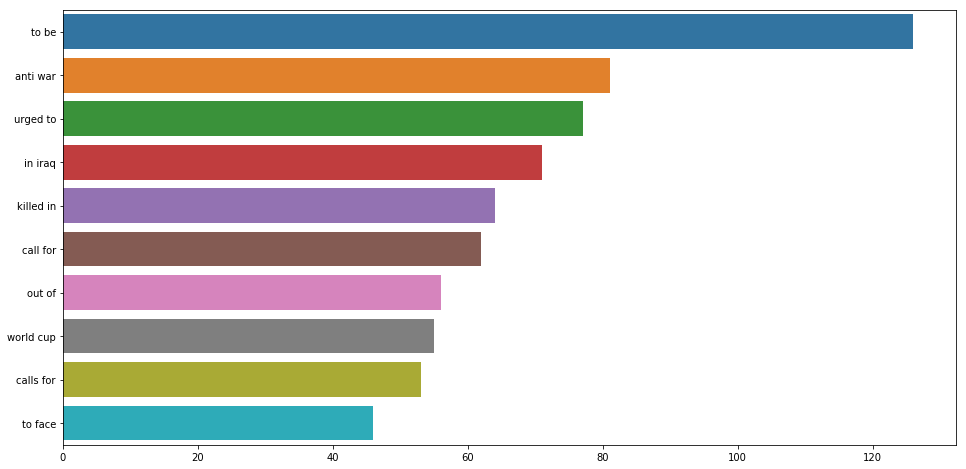

In [119]:
top_n_bigrams=get_top_ngram(news['headline_text'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

#### How about trigrams?

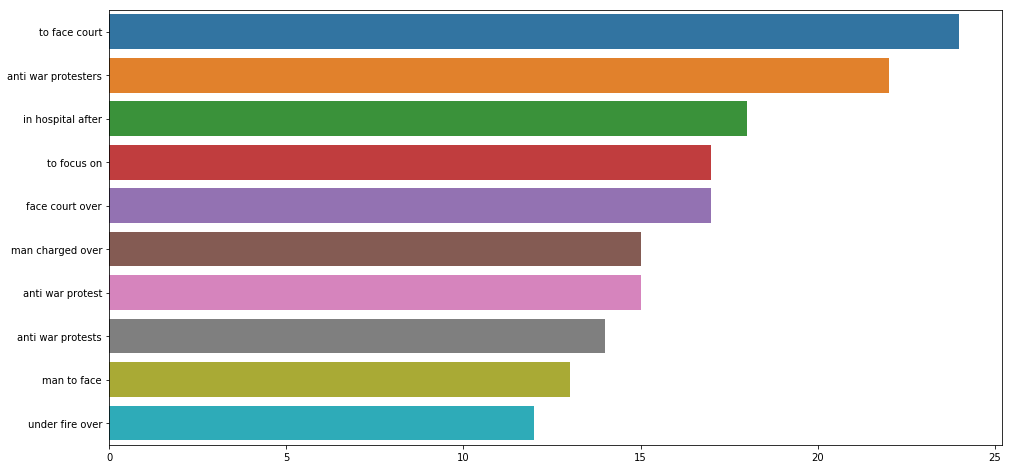

In [120]:
top_tri_grams=get_top_ngram(news['headline_text'],n=3)
x,y = map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

#### Topic Modeling exploration with pyLDAvis

In [121]:
nltk.download('punkt')
nltk.download('wordnet')

def preprocess_news(df):
    corpus = []
    stem = nltk.stem.PorterStemmer()
    lem = nltk.stem.WordNetLemmatizer()
    for news in df['headline_text']:
        words=[w for w in nltk.tokenize.word_tokenize(news) if (w not in stop)]
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        corpus.append(words)
    return corpus

corpus = preprocess_news(news)

[nltk_data] Downloading package punkt to /home/rsouza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/rsouza/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Now, let’s create the bag of words model using gensim

In [122]:
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

#### Create the LDA model:

In [123]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics = 4, id2word = dic, passes = 10, workers = 2,  per_word_topics=True)
lda_model.show_topics()

[(0,
  '0.024*"iraq" + 0.014*"war" + 0.010*"iraqi" + 0.009*"say" + 0.007*"fire" + 0.006*"govt" + 0.005*"force" + 0.005*"back" + 0.004*"attack" + 0.004*"missile"'),
 (1,
  '0.013*"war" + 0.009*"new" + 0.008*"anti" + 0.007*"world" + 0.007*"plan" + 0.006*"protest" + 0.006*"council" + 0.005*"win" + 0.005*"take" + 0.005*"open"'),
 (2,
  '0.015*"police" + 0.014*"man" + 0.008*"baghdad" + 0.008*"crash" + 0.007*"iraq" + 0.007*"rain" + 0.006*"troop" + 0.005*"charged" + 0.005*"say" + 0.004*"water"'),
 (3,
  '0.006*"new" + 0.006*"sars" + 0.006*"claim" + 0.005*"call" + 0.005*"win" + 0.005*"govt" + 0.004*"charge" + 0.004*"woman" + 0.004*"set" + 0.004*"final"')]

#### What is the Dominant topic and its percentage contribution in each document

In [124]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), 
                                                                  round(prop_topic,4), 
                                                                  topic_keywords]), 
                                                       ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(lda_model, bow_corpus, news['headline_text'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             2.0              0.8685   
1            1             0.0              0.8909   
2            2             1.0              0.5348   
3            3             2.0              0.5857   
4            4             2.0              0.8724   
5            5             2.0              0.4251   
6            6             0.0              0.8717   
7            7             2.0              0.9009   
8            8             0.0              0.8710   
9            9             1.0              0.8724   

                                            Keywords  \
0  police, man, baghdad, crash, iraq, rain, troop...   
1  iraq, war, iraqi, say, fire, govt, force, back...   
2  war, new, anti, world, plan, protest, council,...   
3  police, man, baghdad, crash, iraq, rain, troop...   
4  police, man, baghdad, crash, iraq, rain, troop...   
5  police, man, baghdad, crash, iraq, rain, troop...   
6  iraq, war, iraqi, say, fire, govt, force, back...   
7  police, man, baghdad, crash, iraq, rain, troop...   
8  iraq, war, iraqi, say, fire, govt, force, back...   
9  war, new, anti, world, plan, protest, council,...   

                                                Text  
0  aba decides against community broadcasting lic...  
1     act fire witnesses must be aware of defamation  
2     a g calls for infrastructure protection summit  
3           air nz staff in aust strike for pay rise  
4      air nz strike to affect australian travellers  
5                  ambitious olsson wins triple jump  
6         antic delighted with record breaking barca  
7  aussie qualifier stosur wastes four memphis match  
8       aust addresses un security council over iraq  
9         australia is locked into war timetable opp

#### Frequency Distribution of Word Counts in Documents

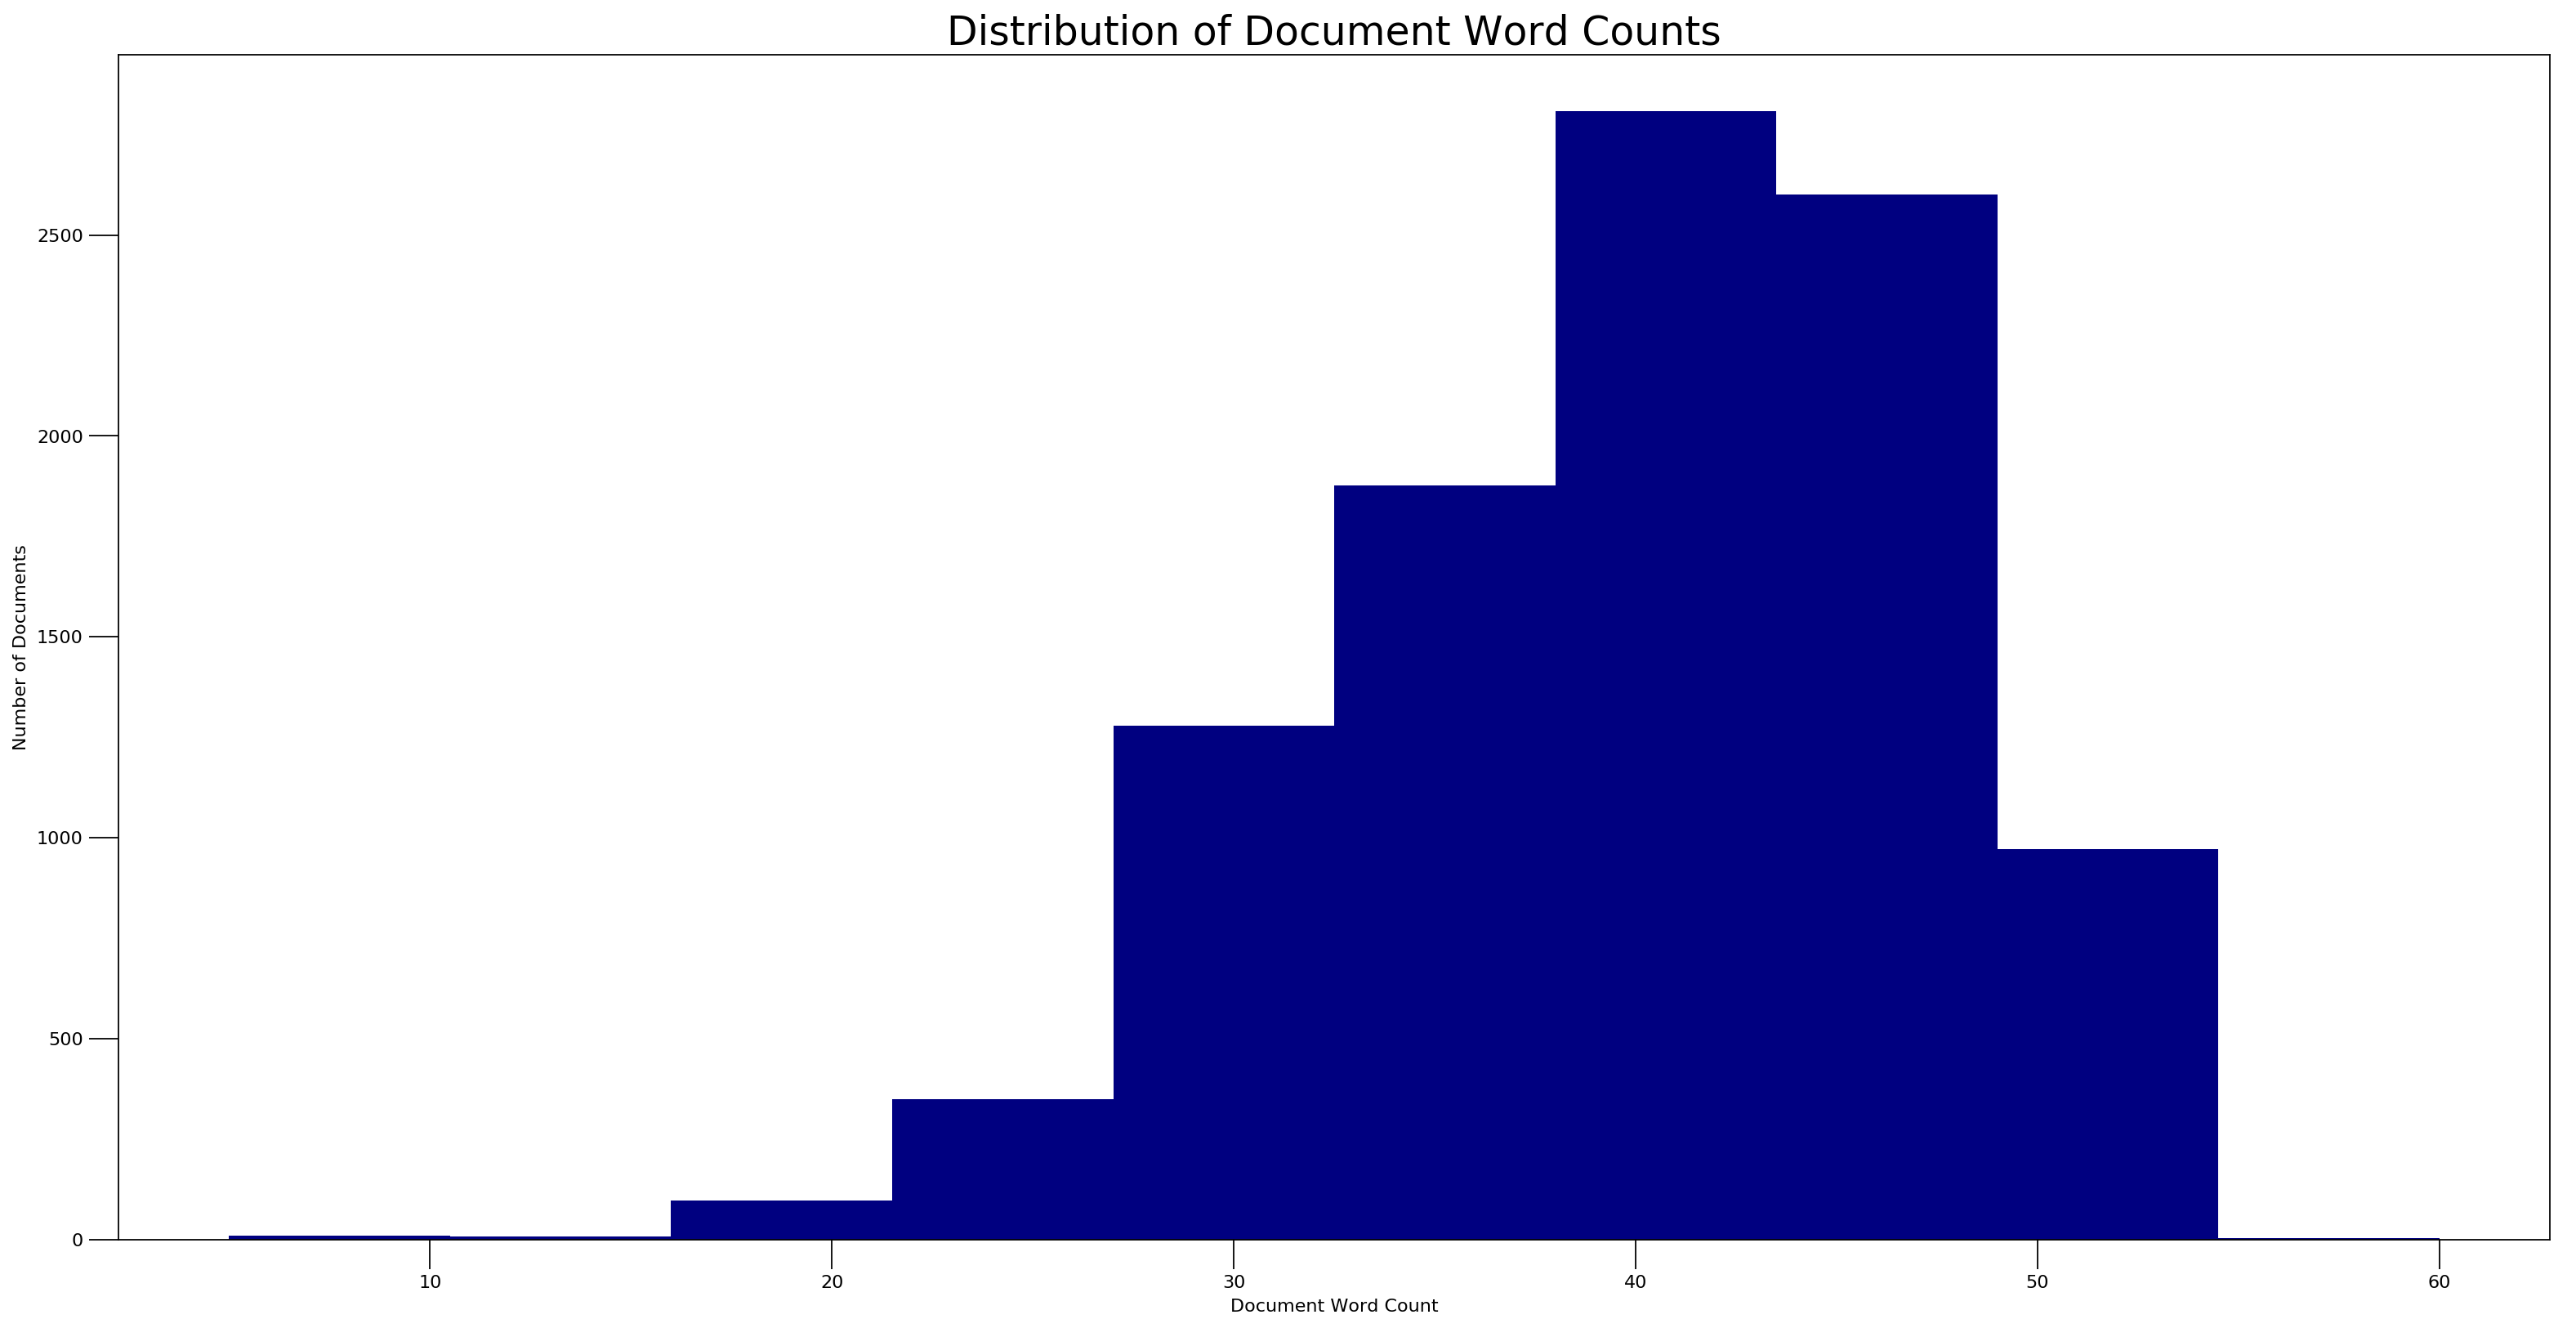

In [125]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(24,12), dpi=160)
plt.hist(doc_lens, color='navy') #, bins = 100)
#plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
#plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
#plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
#plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
#plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(ylabel='Number of Documents', xlabel='Document Word Count',) # xlim=(0, 100),)
plt.tick_params(size=16)
#plt.xticks(np.linspace(0,100,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

#### By Topic

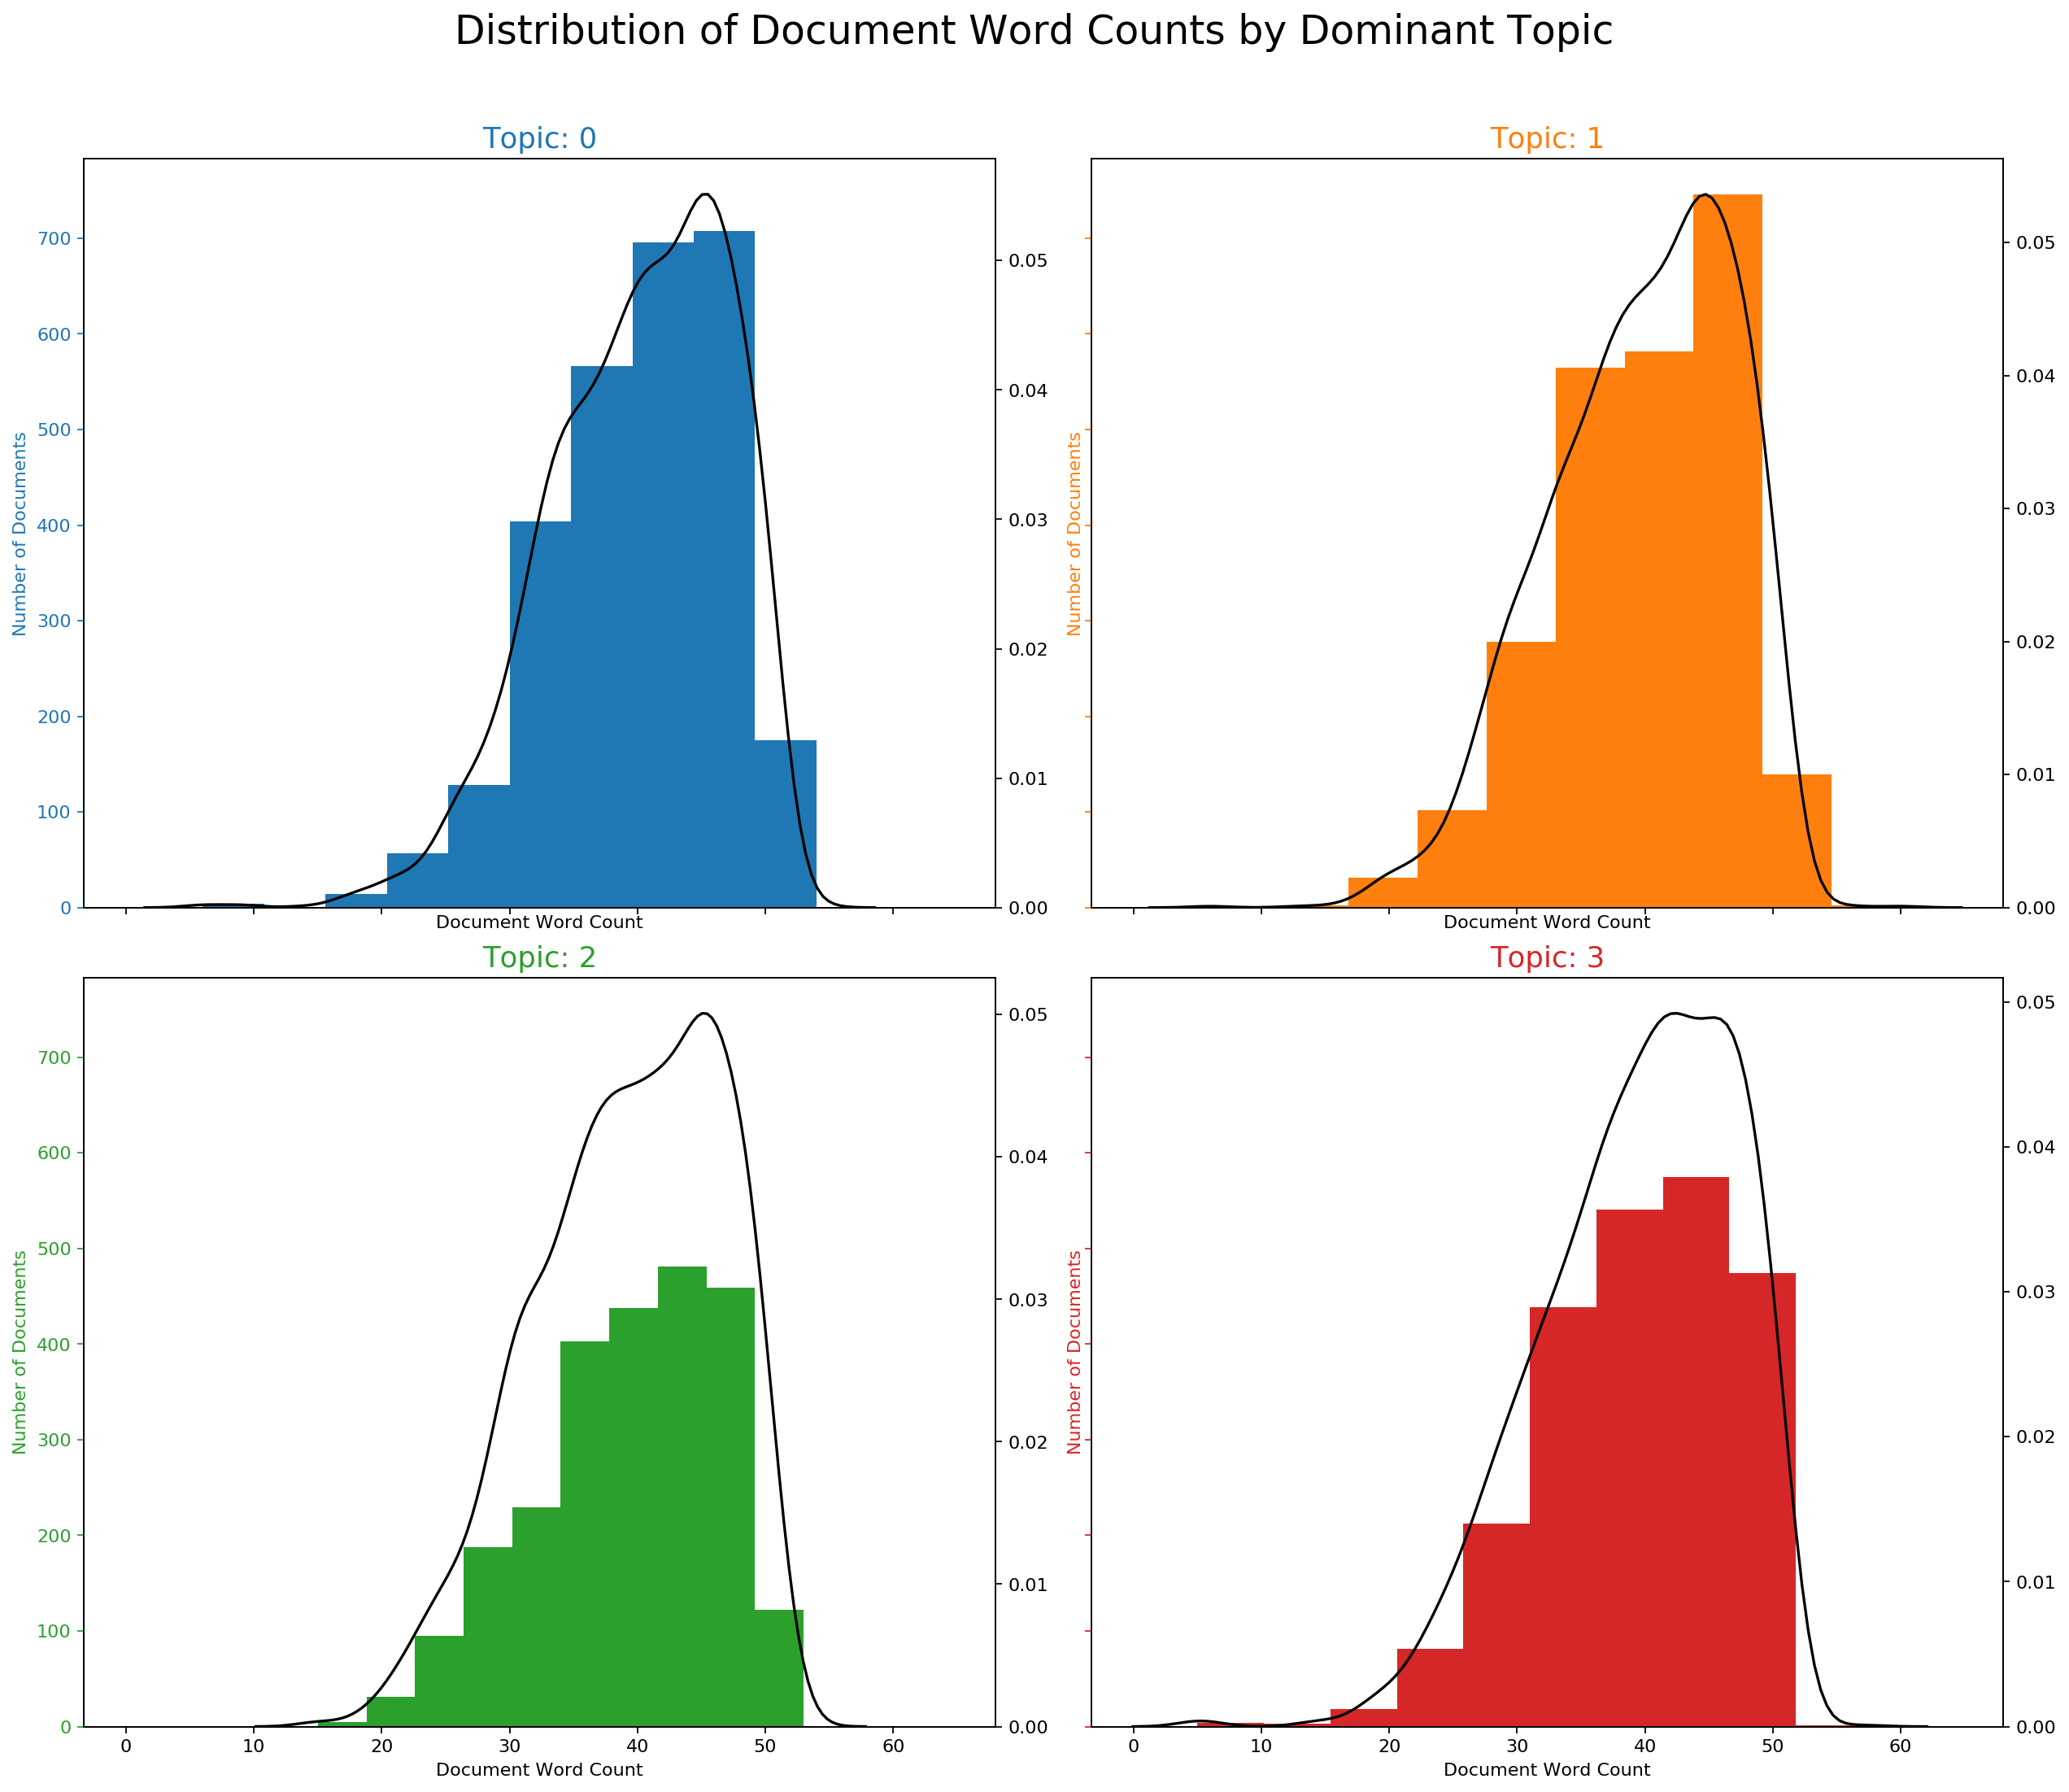

In [126]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, color=cols[i]) #, bins = 1000)
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlabel='Document Word Count') #xlim=(0, 1000),
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
#plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

#### Word Clouds of Top N Keywords in Each Topic

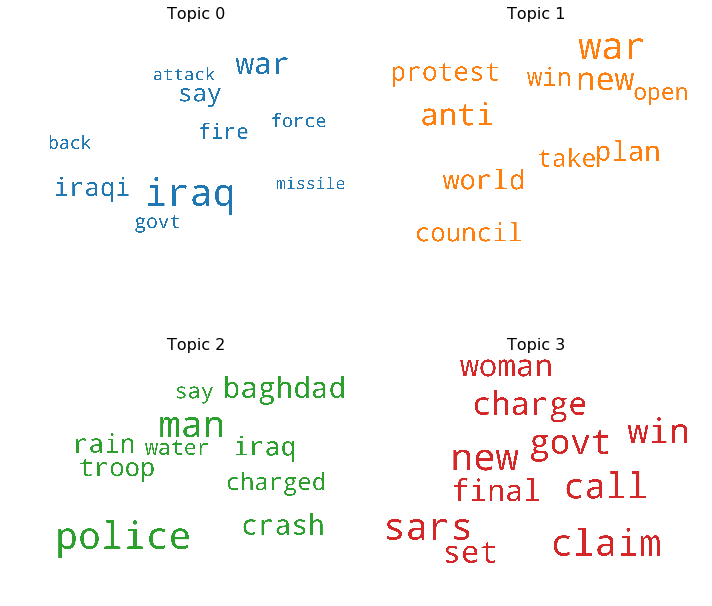

In [127]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#### Word Counts of Topic Keywords

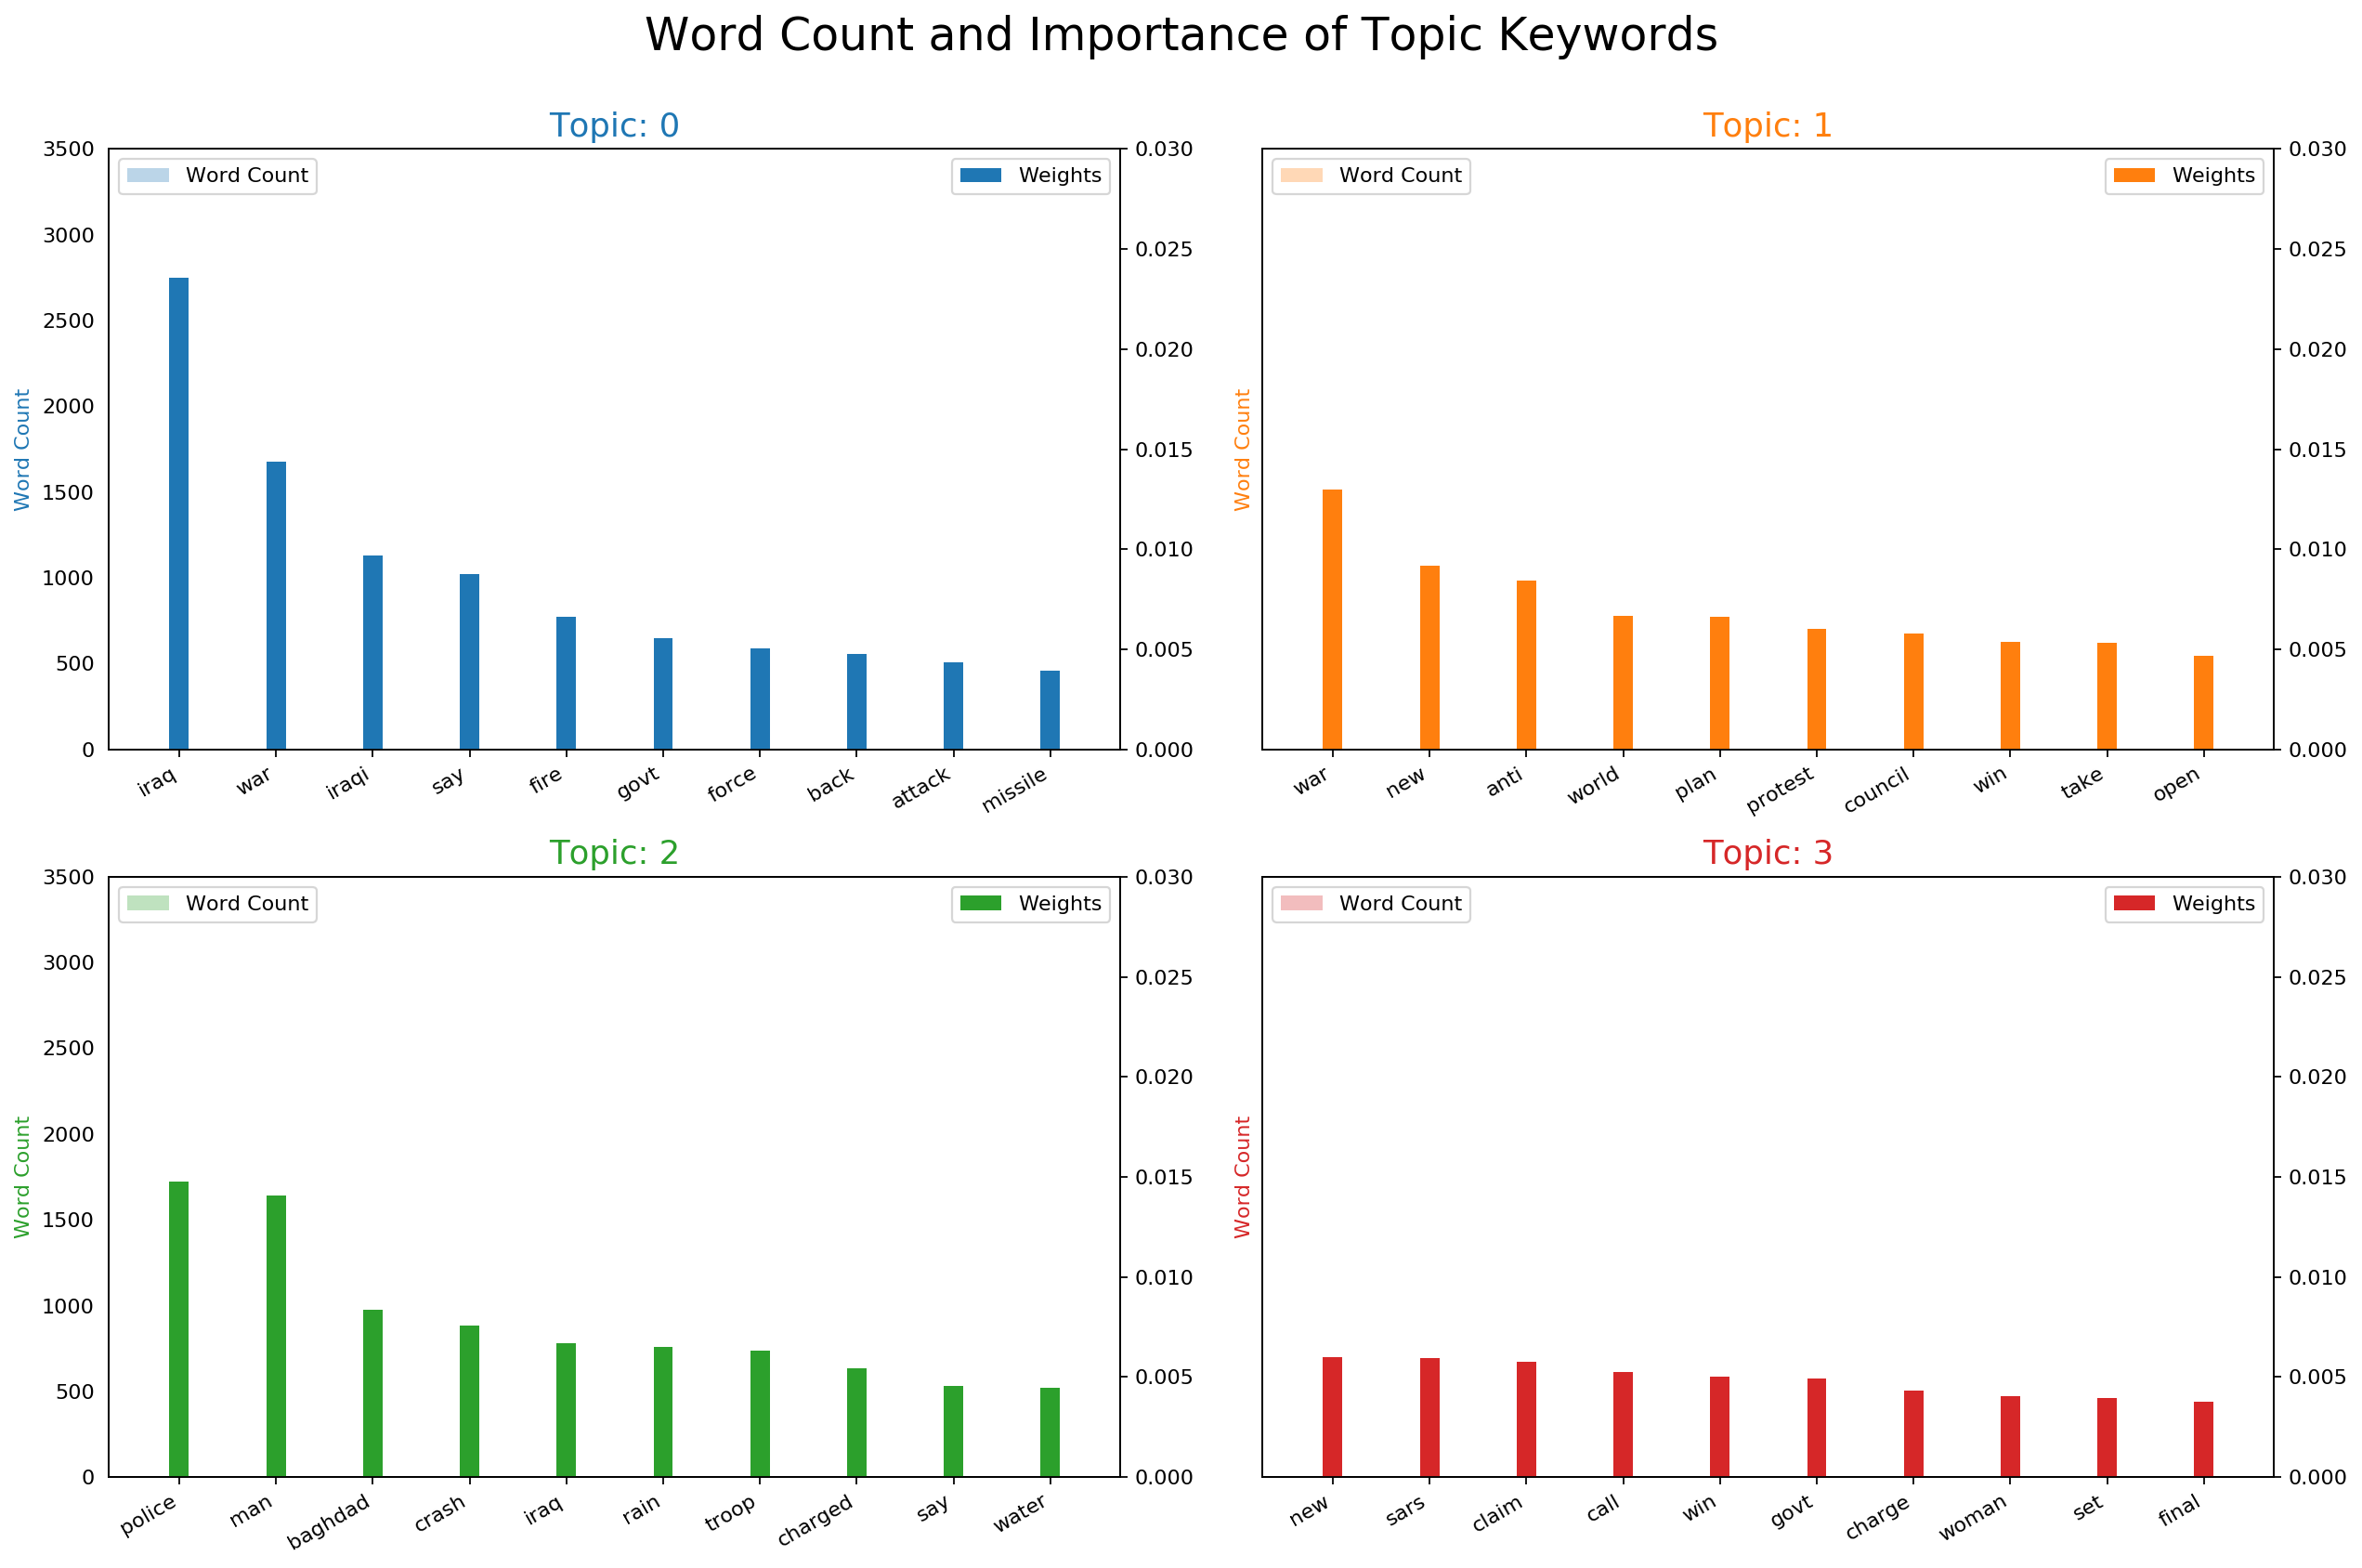

In [128]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in news['headline_text'] for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

#### Sentence Chart Colored by Topic

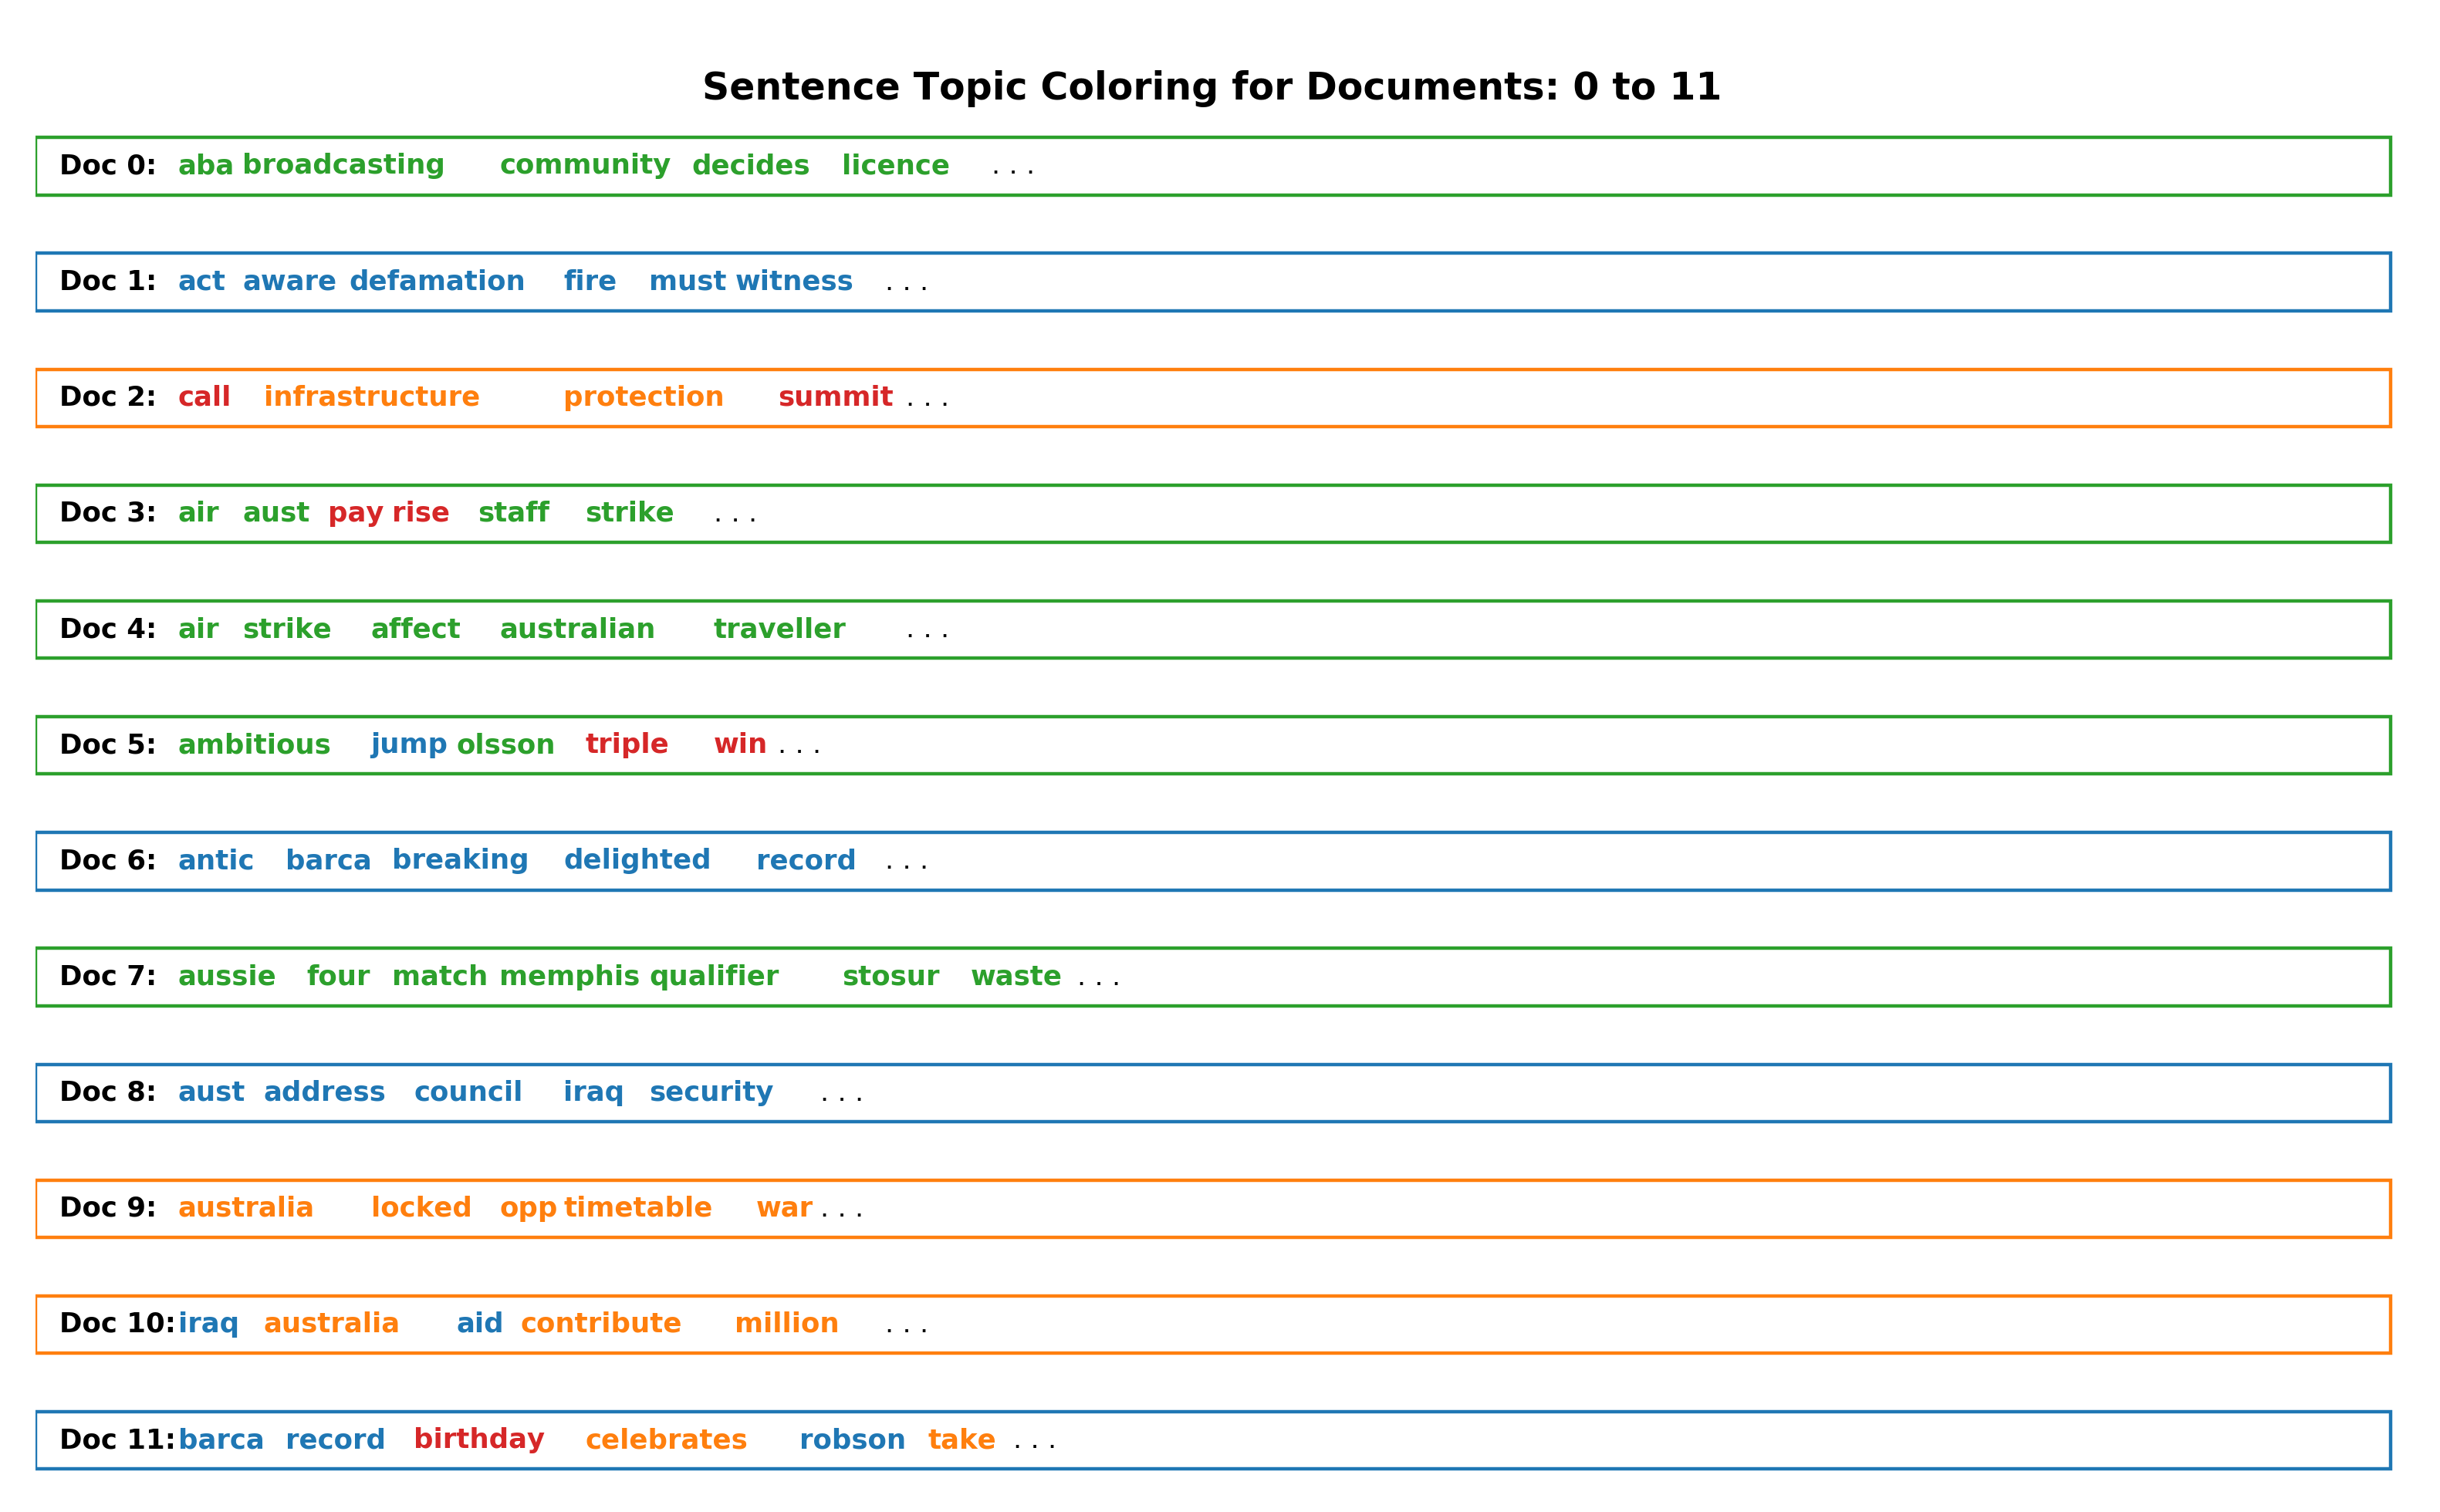

In [129]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model, corpus, start=0, end=13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 
                    0.5, 
                    "Doc " + str(i-1) + ": ", 
                    verticalalignment='center',
                    fontsize=16, 
                    color='black',
                    transform=ax.transAxes, 
                    fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color = mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment = 'left',
                            verticalalignment = 'center',
                            fontsize = 16, color = mycolors[topics],
                            transform = ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
                    
            ax.text(word_pos, 0.5, 
                    '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart(lda_model, bow_corpus)    

#### What are the most discussed topics in the documents?

In [130]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=bow_corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0, inplace=True)

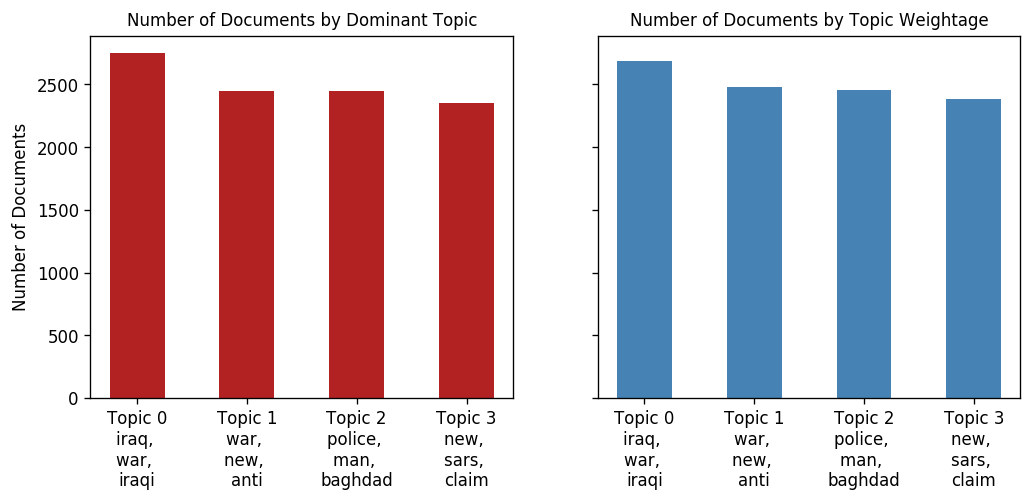

In [131]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
# ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

#### t-SNE Clustering Chart

In [132]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[bow_corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 6
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9980 samples in 0.003s...
[t-SNE] Computed neighbors for 9980 samples in 0.167s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9980
[t-SNE] Computed conditional probabilities for sample 2000 / 9980
[t-SNE] Computed conditional probabilities for sample 3000 / 9980
[t-SNE] Computed conditional probabilities for sample 4000 / 9980
[t-SNE] Computed conditional probabilities for sample 5000 / 9980
[t-SNE] Computed conditional probabilities for sample 6000 / 9980
[t-SNE] Computed conditional probabilities for sample 7000 / 9980
[t-SNE] Computed conditional probabilities for sample 8000 / 9980
[t-SNE] Computed conditional probabilities for sample 9000 / 9980
[t-SNE] Computed conditional probabilities for sample 9980 / 9980
[t-SNE] Mean sigma: 0.000957
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.085052
[t-SNE] KL divergence after 1000 iterations: 0.731704


Loading BokehJS ...

#### Visualizes the results of LDA interactively

In [133]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.000832  0.164130       1        1  26.969921
1      0.106355  0.002673       2        1  25.050774
2     -0.179983 -0.046372       3        1  24.240400
3      0.072796 -0.120431       4        1  23.738907, topic_info=       Term        Freq       Total Category  logprob  loglift
43     iraq  407.000000  407.000000  Default  30.0000  30.0000
49      war  364.000000  364.000000  Default  29.0000  29.0000
317     man  215.000000  215.000000  Default  28.0000  28.0000
588    anti  110.000000  110.000000  Default  27.0000  27.0000
275  police  260.000000  260.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
275  police   44.722694  260.562866   Topic4  -5.6011  -0.3243
249   court   33.105225  109.943169   Topic4  -5.9019   0.2378
199     nsw   31.330402  116.462936   Topic4  -5.9570   0.1251
8      fire   30.932898  148.764160   Topic4  -5.9697  -0.1325
254    back   30.393719  114.712997   Topic4  -5.9873   0.1099

[289 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1084      1  0.025288  accident
1084      3  0.177014  accident
1084      4  0.809208  accident
5         1  0.591443       act
5         3  0.260931       act
...     ...       ...       ...
488       1  0.008635     world
488       2  0.733933     world
488       3  0.017269     world
488       4  0.233132     world
2426      3  0.974833       yet

[494 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

#### Wordcloud

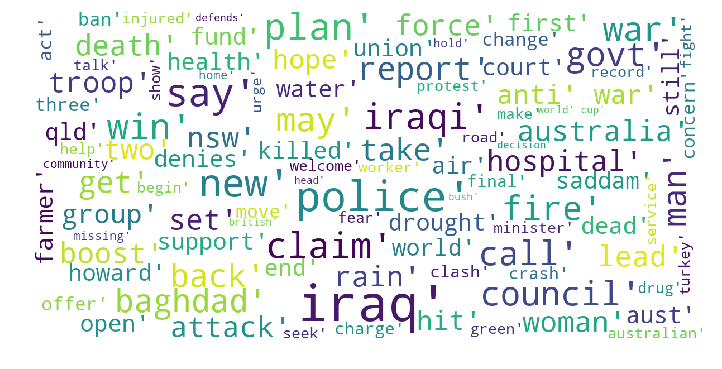

In [134]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

#### Sentiment analysis

In [135]:
from textblob import TextBlob
TextBlob('100 people killed in Iraq').sentiment

Sentiment(polarity=-0.2, subjectivity=0.0)

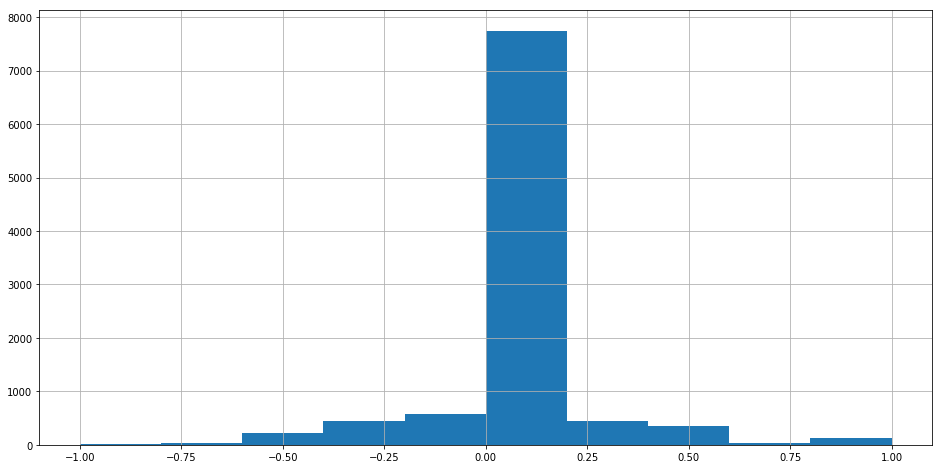

In [136]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

news['polarity_score'] = news['headline_text'].apply(lambda x : polarity(x))
news['polarity_score'].hist()

#### Let’s dig a bit deeper by classifying the news as negative, positive and neutral based on the scores.

<BarContainer object of 3 artists>

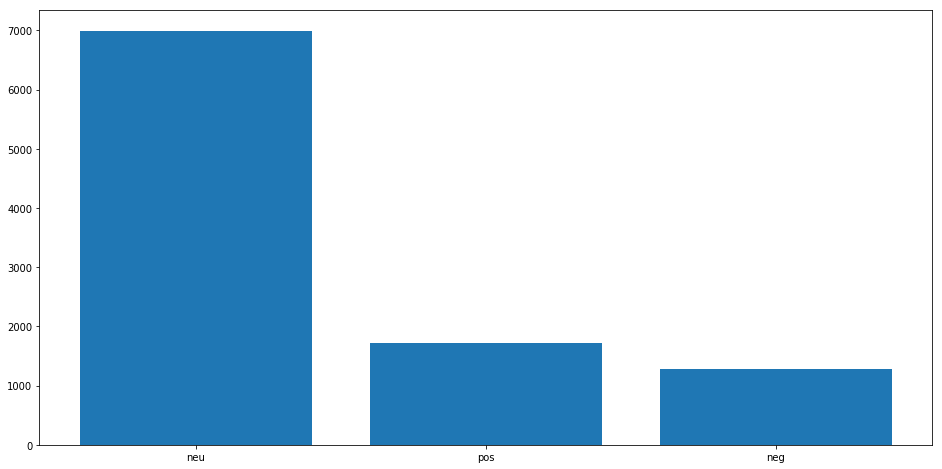

In [137]:
def sentiment(x):
    if x < 0:
        return 'neg'
    elif x == 0:
        return 'neu'
    else:
        return 'pos'
    
news['polarity']=news['polarity_score'].map(lambda x: sentiment(x))
plt.bar(news.polarity.value_counts().index, news.polarity.value_counts())

In [138]:
news[news['polarity'] == 'pos']['headline_text'].head()

1     act fire witnesses must be aware of defamation
5                  ambitious olsson wins triple jump
6         antic delighted with record breaking barca
18        bryant leads lakers to double overtime win
26      commonwealth bank cuts fixed home loan rates
Name: headline_text, dtype: object

In [139]:
news[news['polarity'] == 'neg']['headline_text'].head()

7     aussie qualifier stosur wastes four memphis match
23               carews freak goal leaves roma in ruins
28     council chief executive fails to secure position
34                   dargo fire threat expected to rise
40        direct anger at govt not soldiers crean urges
Name: headline_text, dtype: object

#### Vader Sentiment Analysis

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/rsouza/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<BarContainer object of 3 artists>

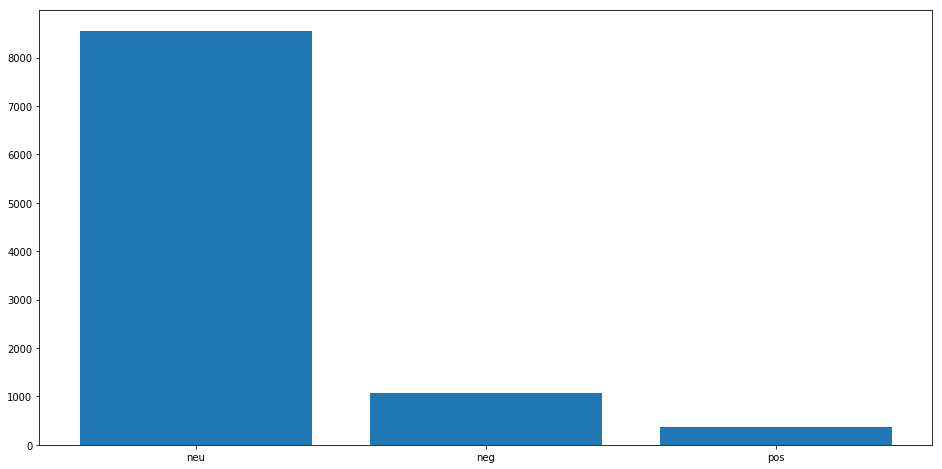

In [140]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    #return ss
    return np.argmax(list(ss.values())[:-1])

news['polarity']=news['headline_text'].map(lambda x: get_vader_score(x))
polarity=news['polarity'].replace({0:'neg',1:'neu',2:'pos'})

plt.bar(polarity.value_counts().index, polarity.value_counts())

#### Named Entity Recognition

In [141]:
# ! python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm")

In [142]:
doc = nlp('India and Iran have agreed to boost the economic viability \
of the strategic Chabahar port through various measures, \
including larger subsidies to merchant shipping firms using the facility, \
people familiar with the development said on Thursday.')

[(x.text,x.label_) for x in doc.ents]

[('India', 'GPE'),
 ('Iran', 'GPE'),
 ('Chabahar', 'PERSON'),
 ('Thursday', 'DATE')]

In [143]:
from spacy import displacy

displacy.render(doc, style='ent')

In [144]:
def ner(text):
    doc = nlp(text)
    return [X.label_ for X in doc.ents]

ent = news['headline_text'].apply(lambda x : ner(x))
ent = [x for sub in ent for x in sub]

counter = Counter(ent)
count = counter.most_common()

#### Now, we can visualize the entity frequencies: 

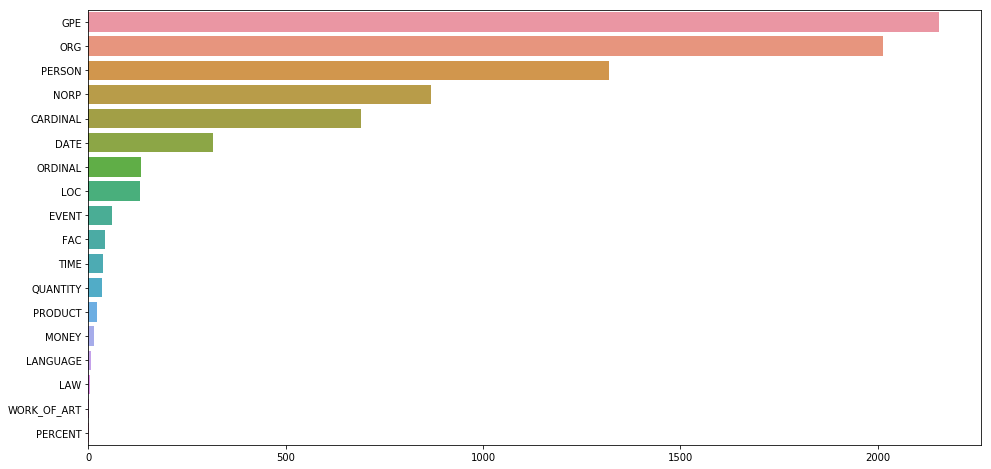

In [145]:
x,y = map(list,zip(*count))
sns.barplot(x=y, y=x)

#### We can also visualize the most common tokens per entity

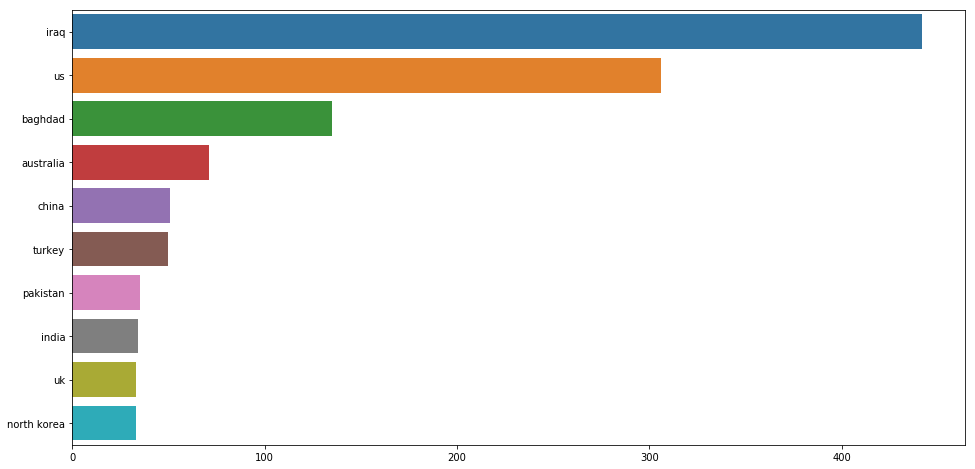

In [146]:
def ner(text,ent = "GPE"):
    doc = nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

gpe = news['headline_text'].apply(lambda x: ner(x))
gpe = [i for x in gpe for i in x]
counter = Counter(gpe)

x,y = map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

#### Most common names on News headlines

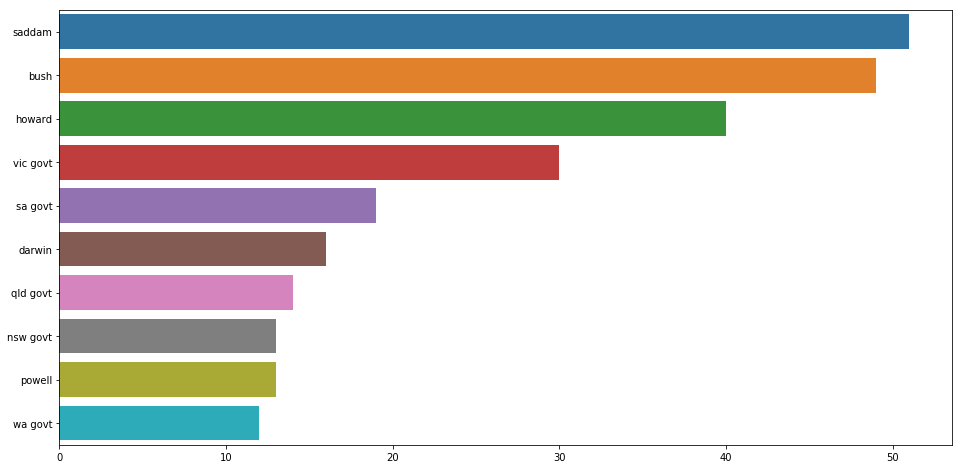

In [147]:
per = news['headline_text'].apply(lambda x: ner(x,"PERSON"))
per = [i for x in per for i in x]
counter = Counter(per)

x,y = map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

#### Exploration through Parts of Speach Tagging in python

In [148]:
import nltk
sentence = "The greatest comeback stories in 2019"
tokens = nltk.tokenize.word_tokenize(sentence)
nltk.pos_tag(tokens)

[('The', 'DT'),
 ('greatest', 'JJS'),
 ('comeback', 'NN'),
 ('stories', 'NNS'),
 ('in', 'IN'),
 ('2019', 'CD')]

In [149]:
doc = nlp('The greatest comeback stories in 2019')
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

#### Now that we now what POS tagging is, let’s use it to explore our headlines dataset

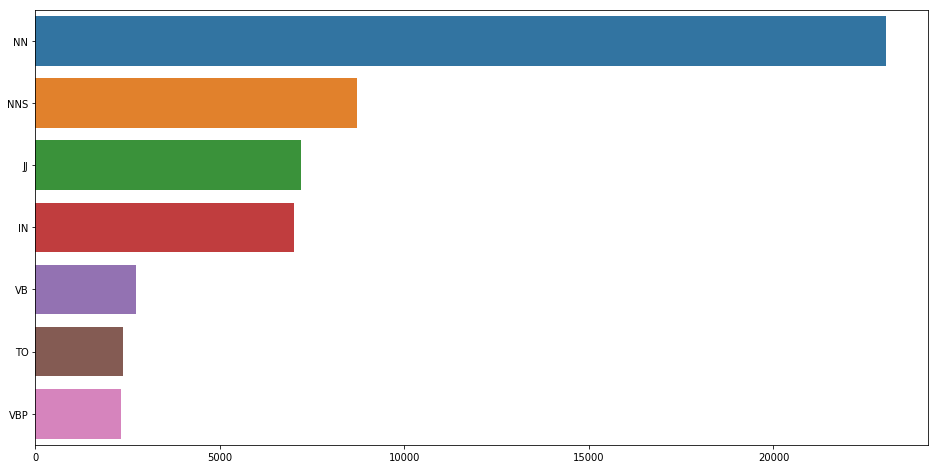

In [150]:
def pos(text):
    pos = nltk.pos_tag(nltk.tokenize.word_tokenize(text))
    pos = list(map(list,zip(*pos)))[1]
    return pos

tags = news['headline_text'].apply(lambda x : pos(x))
tags = [x for l in tags for x in l]
counter = Counter(tags)

x,y = list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

#### We can dig deeper into this by investigating which singular noun occur most commonly in news headlines

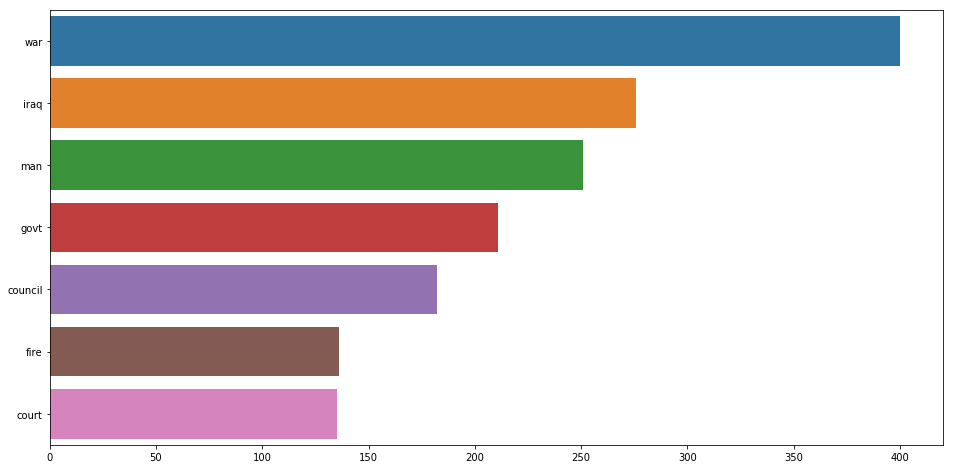

In [151]:
def get_adjs(text):
    adj = []
    pos = nltk.pos_tag(nltk.tokenize.word_tokenize(text))
    for word,tag in pos:
        if tag == 'NN':
            adj.append(word)
    return adj


words = news['headline_text'].apply(lambda x : get_adjs(x))
words = [x for l in words for x in l]
counter = Counter(words)

x,y = list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

#### Exploring through text complexity  

Readability index is a numeric value that indicates how difficult (or easy) it is to read and understand a text.  

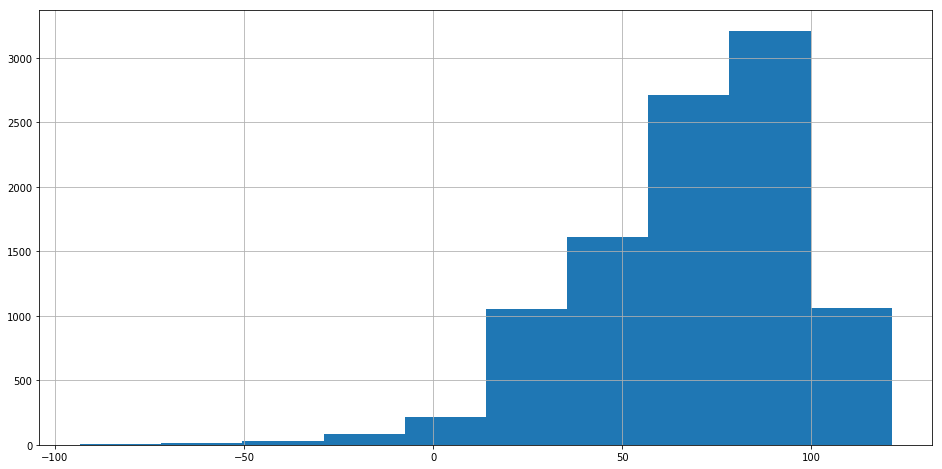

In [152]:
from textstat import flesch_reading_ease

news['headline_text'].apply(lambda x : flesch_reading_ease(x)).hist()

Almost all of the readability scores fall above 60. This means that an average 11-year-old student can read and understand the news headlines. Let’s check all news headlines that have a readability score below 5  

In [153]:
news['reading'] = news['headline_text'].apply(lambda x : flesch_reading_ease(x))
x = [i for i in range(len(news['reading'])) if news['reading'].iloc[i] < 5]
news.iloc[x]['headline_text'].head()

134    policewomen accusations feature at federal crime
150      report highlights container terminal potential
285       groups praise outgoing opposition agriculture
298            investigations underway into qantas skid
308      landholder contribution still under discussion
Name: headline_text, dtype: object

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3ac46674-63e8-43c6-afbc-97dcb432b211' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>